## TCC Expectativa de Vida

## Livrarias importadas

### Pip Install

In [223]:
# !pip install inflection
# !pip install pandas
# !pip install sqlalchemy
# !pip install geopy
# !pip install pycountry-convert
# !pip install seaborn
# !pip install plotly
# !pip install pycountry-convert
# !pip install melt
# !pip install sklearn
# !pip install Image
# !pip install missingno
# !pip install boruta
# !pip install xgboost
# !pip install xlrd

### Import

In [250]:
import pandas                                      as pd
import numpy                                       as np
from geopy.geocoders        import Nominatim
from pycountry_convert      import country_alpha2_to_continent_code,country_name_to_country_alpha2
import inflection
import sqlite3 
from matplotlib             import pyplot          as plt 
from IPython.core.display   import HTML
import seaborn                                     as sns
from IPython.display        import Image
from scipy.stats            import shapiro
from sqlalchemy             import create_engine
import missingno                                   as msno
import plotly.express                              as px
from scipy                  import stats
from sklearn.impute         import KNNImputer
from sklearn.preprocessing  import MinMaxScaler
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing  import RobustScaler
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.linear_model   import LinearRegression,Lasso,Ridge
from sklearn.ensemble       import RandomForestRegressor
from boruta                 import BorutaPy
import xgboost                                     as xgb


import warnings
warnings.filterwarnings('ignore')

### Funçoes auxiliares

In [251]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ): #funcao que realiza cross validation

    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['year'].max() - (k*3)
        validation_end_date = x_training['year'].max() -((k-1)*3)
        # filtering dataset
        training = x_training[x_training['year'] < validation_start_date]
        validation = x_training[(x_training['year'] >= validation_start_date) & (x_training['year'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['year', 'life_expectancy'], axis=1 ) 
        ytraining = training['life_expectancy']

        # validation
        xvalidation = validation.drop( ['year', 'life_expectancy'], axis=1 )
        yvalidation = validation['life_expectancy']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        #performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 3 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ): 
    '''funçao que retorna o erro percentual medio'''
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    '''funçao que retorna o percentual do erro medio absoluto'''
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    '''funçao que retorna um dataframe com os indicadores de performance'''
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ): 
    '''funçao que retorna a matrix de crammer'''
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )




def jupyter_settings(): 
    '''funçao que define os parametros do %notebook'''
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:75% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
# Supress Scientific Notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

##  Aquisiçao de dados

### Dataset Expectativa de vida

In [277]:
# **1** Dataframe da OMS e das Nações Unidas com a variavel life-expectation
df_expec=pd.read_csv('../Datasets/Life_Expectancy_Data.csv',parse_dates=[1])
df_expec.head()

Country       Year      Status  Life expectancy   Adult Mortality  infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles    BMI   under-five deaths   Polio  Total expenditure  Diphtheria    HIV/AIDS    GDP  Population   thinness  1-19 years   thinness 5-9 years  Income composition of resources  Schooling
0  Afghanistan 2015-01-01  Developing             65.00           263.00             62     0.01                   71.28        65.00      1154  19.10                  83   6.00               8.16        65.00       0.10 584.26 33736494.00                  17.20                17.30                             0.48      10.10
1  Afghanistan 2014-01-01  Developing             59.90           271.00             64     0.01                   73.52        62.00       492  18.60                  86  58.00               8.18        62.00       0.10 612.70   327582.00                  17.50                17.50                             0.48      10.00
2  Afghanistan 2013-01-01  Developing             59.90           268.00             66     0.01                   73.22        64.00       430  18.10                  89  62.00               8.13        64.00       0.10 631.74 31731688.00                  17.70                17.70                             0.47       9.90
3  Afghanistan 2012-01-01  Developing             59.50           272.00             69     0.01                   78.18        67.00      2787  17.60                  93  67.00               8.52        67.00       0.10 669.96  3696958.00                  17.90                18.00                             0.46       9.80
4  Afghanistan 2011-01-01  Developing             59.20           275.00             71     0.01                    7.10        68.00      3013  17.20                  97  68.00               7.87        68.00       0.10  63.54  2978599.00                  18.20                18.20                             0.45       9.50

In [278]:
print('numero de linhas:{}'.format(df_expec.shape[0]))
print('numero de colunas:{}'.format(df_expec.shape[1]))

numero de linhas:2938
numero de colunas:22


### Dataset Emission

In [279]:
#  **2** Dataframe com emissao de dados
df_emi=pd.read_csv('../Datasets/emission data.csv')
df_emi.head()

Country  1751  1752  1753  1754  1755  1756  1757  1758  1759  1760  1761  1762  1763  1764  1765  1766  1767  1768  1769  1770  1771  1772  1773  1774  1775  1776  1777  1778  1779  1780  1781  1782  1783  1784  1785  1786   1787   1788   1789   1790   1791   1792   1793   1794   1795   1796   1797   1798   1799   1800   1801   1802   1803   1804   1805   1806   1807   1808   1809   1810   1811    1812    1813    1814    1815    1816    1817    1818    1819    1820    1821    1822    1823    1824    1825    1826    1827    1828    1829    1830    1831    1832    1833    1834    1835    1836    1837    1838    1839    1840    1841    1842    1843    1844    1845    1846    1847    1848    1849    1850    1851    1852    1853    1854    1855     1856     1857     1858     1859     1860     1861     1862     1863     1864     1865     1866     1867     1868      1869      1870      1871      1872      1873      1874      1875      1876      1877      1878      1879      1880      1881      1882      1883      1884      1885      1886      1887       1888       1889       1890       1891       1892       1893       1894       1895       1896       1897       1898       1899       1900       1901       1902       1903       1904       1905       1906       1907       1908       1909       1910       1911        1912        1913        1914        1915        1916        1917        1918        1919          1920          1921          1922          1923          1924          1925          1926          1927          1928          1929          1930          1931          1932          1933          1934          1935          1936          1937          1938          1939          1940          1941          1942          1943          1944          1945          1946          1947          1948          1949          1950          1951          1952          1953           1954           1955           1956           1957           1958           1959           1960           1961           1962           1963           1964           1965           1966           1967           1968           1969           1970           1971           1972           1973           1974           1975           1976           1977           1978           1979           1980           1981           1982           1983           1984           1985           1986           1987           1988           1989           1990           1991           1992           1993           1994           1995           1996           1997           1998           1999           2000           2001           2002           2003           2004           2005           2006           2007           2008           2009           2010           2011           2012           2013           2014           2015           2016           2017
0       Afghanistan     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0        0        0        0        0        0        0        0        0        0        0        0        0        0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0          0          0          0          0          0          0          0

#### Verificaçao do nomes em country da tabela emissao


In [280]:
countryISO=df_expec['Country'].unique()
emissioncountry=df_emi['Country'].unique()
(set(countryISO) ^ set(emissioncountry))-set(countryISO)
(set(countryISO) ^ set(emissioncountry))-set(emissioncountry)

{'Bolivia (Plurinational State of)',
 'Brunei Darussalam',
 'Cabo Verde',
 'Czechia',
 "Côte d'Ivoire",
 "Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 'Iran (Islamic Republic of)',
 "Lao People's Democratic Republic",
 'Micronesia (Federated States of)',
 'Monaco',
 'Republic of Korea',
 'Republic of Moldova',
 'Russian Federation',
 'San Marino',
 'Syrian Arab Republic',
 'The former Yugoslav republic of Macedonia',
 'Timor-Leste',
 'United Kingdom of Great Britain and Northern Ireland',
 'United Republic of Tanzania',
 'United States of America',
 'Venezuela (Bolivarian Republic of)',
 'Viet Nam'}

In [281]:
countryISO_unmatch=['Bolivia (Plurinational State of)',
 'Brunei Darussalam',
 'Cabo Verde',
 'Czechia',
 "Côte d'Ivoire",
 "Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 'Iran (Islamic Republic of)',
 "Lao People's Democratic Republic",
 'Micronesia (Federated States of)',
 'Republic of Korea',
 'Republic of Moldova',
 'Russian Federation',
 'Syrian Arab Republic',
 'The former Yugoslav republic of Macedonia',
 'Timor-Leste',
 'United Kingdom of Great Britain and Northern Ireland',
 'United Republic of Tanzania',
 'United States of America',
 'Venezuela (Bolivarian Republic of)',
 'Viet Nam']

countryemission_unmatch=['Bolivia','Brunei',
 'Cape Verde', 'Czech Republic', "Cote d'Ivoire",'North Korea','Democratic Republic of Congo','Iran','Laos', 'Micronesia (country)', 'South Korea','Moldova','Russia','Syria','Macedonia', 'Timor','United Kingdom','Tanzania','United States','Venezuela', 'Vietnam']

dictemi = dict(zip(countryemission_unmatch,countryISO_unmatch))
df_emi['Country']=df_emi['Country'].replace(dictemi)

In [282]:
# Building DataFrame 
df_emi=df_emi[['Country','2000','2001','2002','2003','2004','2005','2006','2007','2008',
               '2009','2010', '2011', '2012', '2013', '2014', '2015']]

df_emi=df_emi.melt(id_vars=['Country'])  # empilha os dados com granularidade em country
df_emi.columns=['Country','Year','Emission']

df_emi.head()

Country  Year       Emission
0       Afghanistan  2000    71717793.00
1            Africa  2000 23640083267.00
2           Albania  2000   196932672.00
3           Algeria  2000  2118624684.00
4  Americas (other)  2000 60974588046.00

### Dataset Demographics

In [283]:
# **3** Dataframe com a populaçao separada em masculina feminina e demografia
df_demo=pd.read_csv('../Datasets/WPP2019_TotalPopulationBySex.csv')
df_demo.head()

LocID     Location  VarID Variant  Time  MidPeriod  PopMale  PopFemale  PopTotal  PopDensity
0      4  Afghanistan      2  Medium  1950    1950.50  4099.24    3652.87   7752.12       11.87
1      4  Afghanistan      2  Medium  1951    1951.50  4134.76    3705.39   7840.15       12.01
2      4  Afghanistan      2  Medium  1952    1952.50  4174.45    3761.55   7936.00       12.16
3      4  Afghanistan      2  Medium  1953    1953.50  4218.34    3821.35   8039.68       12.31
4      4  Afghanistan      2  Medium  1954    1954.50  4266.48    3884.83   8151.32       12.49

#### Verificaçao do nomes em country da tabela demo

In [284]:
countryISO=df_expec['Country'].unique()
democountry=df_demo['Location'].unique()
(set(countryISO) ^ set(democountry))-set(countryISO)
print((set(countryISO) ^ set(democountry))-set(democountry))


{'The former Yugoslav republic of Macedonia', 'United Kingdom of Great Britain and Northern Ireland', "Democratic People's Republic of Korea", 'Swaziland', 'Micronesia (Federated States of)'}


In [285]:
countryISO_unmatch=["Democratic People's Republic of Korea",'Micronesia (Federated States of)', 'The former Yugoslav republic of Macedonia', 'United Kingdom of Great Britain and Northern Ireland']

countrydemo_unmatch=["Dem. People's Republic of Korea", 'Micronesia (Fed. States of)','North Macedonia', 'United Kingdom (and dependencies)']

dictdemo = dict(zip(countrydemo_unmatch,countryISO_unmatch))
df_demo['Location']=df_demo['Location'].replace(dictdemo)

In [286]:
## Seleçao das colunas 
df_demo=df_demo.loc[(df_demo['Time']>=2000 )& (df_demo['Time']<=2015),['Location','Time','PopMale','PopFemale','PopTotal','PopDensity']]
df_demo.columns=['Country','Year','Pop male','Pop female','Pop total','Density']

In [287]:
df_demo.head()

Country  Year  Pop male  Pop female  Pop total  Density
50  Afghanistan  2000  10689.51    10090.45   20779.96    31.83
51  Afghanistan  2001  11117.75    10489.24   21606.99    33.10
52  Afghanistan  2002  11642.11    10958.67   22600.77    34.62
53  Afghanistan  2003  12214.63    11466.24   23680.87    36.27
54  Afghanistan  2004  12763.73    11962.96   24726.69    37.87

### Merge Datasets

In [288]:
# Trasforming variable date
df_demo['Year']=df_demo['Year'].astype(str)
df_emi['Year'] = pd.to_datetime( df_emi['Year'] ).dt.strftime('%Y')
df_expec['Year'] = pd.to_datetime( df_expec['Year'] ).dt.strftime('%Y')
df_demo['Year'] = pd.to_datetime( df_demo['Year']).dt.strftime('%Y')

In [289]:
# Merge Dataframes

df=pd.merge(df_expec,df_emi,how='left',on=['Country','Year'])
df=pd.merge(df,df_demo,how='left',on=['Country','Year'])
df=df.drop(['Population'], axis=1)
df.head()

Country  Year      Status  Life expectancy   Adult Mortality  infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles    BMI   under-five deaths   Polio  Total expenditure  Diphtheria    HIV/AIDS    GDP   thinness  1-19 years   thinness 5-9 years  Income composition of resources  Schooling     Emission  Pop male  Pop female  Pop total  Density
0  Afghanistan  2015  Developing             65.00           263.00             62     0.01                   71.28        65.00      1154  19.10                  83   6.00               8.16        65.00       0.10 584.26                  17.20                17.30                             0.48      10.10 153230277.00  17686.17    16727.44   34413.60    52.71
1  Afghanistan  2014  Developing             59.90           271.00             64     0.01                   73.52        62.00       492  18.60                  86  58.00               8.18        62.00       0.10 612.70                  17.50                17.50                             0.48      10.00 143122849.00  17138.80    16232.00   33370.80    51.12
2  Afghanistan  2013  Developing             59.90           268.00             66     0.01                   73.22        64.00       430  18.10                  89  62.00               8.13        64.00       0.10 631.74                  17.70                17.70                             0.47       9.90 133333663.00  16554.28    15715.31   32269.59    49.43
3  Afghanistan  2012  Developing             59.50           272.00             69     0.01                   78.18        67.00      2787  17.60                  93  67.00               8.52        67.00       0.10 669.96                  17.90                18.00                             0.46       9.80 123333249.00  15964.87    15196.50   31161.38    47.73
4  Afghanistan  2011  Developing             59.20           275.00             71     0.01                    7.10        68.00      3013  17.20                  97  68.00               7.87        68.00       0.10  63.54                  18.20                18.20                             0.45       9.50 112591192.00  15415.36    14702.05   30117.41    46.13

### DF2 API geolocation 


In [290]:
## Return latitude
def geolocate_lat(country):
    geolocator = Nominatim(user_agent='catuserbot')

    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude
        return loc.latitude
   
    except:
        # Return missing value
        return np.nan
    
## Return longitude
def geolocate_long(country):
    geolocator = Nominatim(user_agent='catuserbot')

    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return longitude
        return loc.longitude
   
    except:
        # Return missing value
        return np.nan
    



In [291]:
# api that get lat and long for each country (takes 2 hours to run)
#df['lat'],df['long']=df['Country'].apply(lambda x: geolocate_lat(x)),df['Country'].apply(lambda x: geolocate_long(x))

In [292]:
#df.to_csv('Datasets/DF_complete.csv',index=False) #create a file con lat and long because the procedure takes 2 hours to run. 

In [293]:
df= pd.read_csv('../Datasets/DF_complete.csv')

### Populating Country code and continent code from function 

In [294]:

#function to convert to alpah2 country codes 


def get_code(col):
    try:
        cn_a2_code = country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown'
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown'
    return (cn_a2_code)

#function to convert to alpah2 country continent

def get_continent(col):
    try:
        cn_a2_code = country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown'
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown'
    return (cn_continent)

In [295]:
df['continent'],df['code']=df['Country'].apply(lambda x: get_continent(x)),df['Country'].apply(lambda x: get_code(x))

In [296]:
aux = df.loc[df['continent']=='Unknown','Country'].unique()
aux

array(['Bolivia (Plurinational State of)', 'Iran (Islamic Republic of)',
       'Micronesia (Federated States of)', 'Republic of Korea',
       'The former Yugoslav republic of Macedonia', 'Timor-Leste',
       'Venezuela (Bolivarian Republic of)'], dtype=object)

In [297]:
cont=['SA','AS','OC','AS','EU','AS','SA']

In [298]:
for i in range(len(aux)):
    for j in range(len(df)):
        if aux[i] == df.loc[j,'Country'] :
            df.loc[j,'continent']=cont[i]

### Changing columns name

In [299]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Emission', 'Pop male', 'Pop female', 'Pop total', 'Density', 'lat',
       'long', 'continent', 'code'],
      dtype='object')

In [303]:
cols_original=['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Emission', 'Pop male', 'Pop female', 'Pop total', 'Density', 'lat',
       'long', 'continent', 'code']

# snakecase = lambda x: inflection.underscore(x)
# cols = list(map(snakecase,cols_original))
# df.columns=cols


cols=['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'gdp', 'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling',
       'emission', 'pop_male', 'pop_female', 'pop_total', 'density','lat', 'long',
       'continent', 'code']

df.columns=cols

In [304]:
df.head()

country  year      status  life_expectancy  adult_mortality  infant_deaths  alcohol  percentage_expenditure  hepatitis_b  measles   bmi  under_five_deaths  polio  total_expenditure  diphtheria  hiv_aids    gdp  thinness_1_19_years  thinness_5_9_years  income_composition_of_resources  schooling     emission  pop_male  pop_female  pop_total  density   lat  long continent code
0  Afghanistan  2015  Developing            65.00           263.00             62     0.01                   71.28        65.00     1154 19.10                 83   6.00               8.16       65.00      0.10 584.26                17.20               17.30                             0.48      10.10 153230277.00  17686.17    16727.44   34413.60    52.71 33.77 66.24        AS   AF
1  Afghanistan  2014  Developing            59.90           271.00             64     0.01                   73.52        62.00      492 18.60                 86  58.00               8.18       62.00      0.10 612.70                17.50               17.50                             0.48      10.00 143122849.00  17138.80    16232.00   33370.80    51.12 33.77 66.24        AS   AF
2  Afghanistan  2013  Developing            59.90           268.00             66     0.01                   73.22        64.00      430 18.10                 89  62.00               8.13       64.00      0.10 631.74                17.70               17.70                             0.47       9.90 133333663.00  16554.28    15715.31   32269.59    49.43 33.77 66.24        AS   AF
3  Afghanistan  2012  Developing            59.50           272.00             69     0.01                   78.18        67.00     2787 17.60                 93  67.00               8.52       67.00      0.10 669.96                17.90               18.00                             0.46       9.80 123333249.00  15964.87    15196.50   31161.38    47.73 33.77 66.24        AS   AF
4  Afghanistan  2011  Developing            59.20           275.00             71     0.01                    7.10        68.00     3013 17.20                 97  68.00               7.87       68.00      0.10  63.54                18.20               18.20                             0.45       9.50 112591192.00  15415.36    14702.05   30117.41    46.13 33.77 66.24        AS   AF

## Data Preparation

In [305]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [306]:
df1=df.copy()

### Creating **Features**

In [307]:
# female percent
df1['perc_female']=df1['pop_female']/df1['pop_total']

# emission per population tax
df1['emission_pop']=df1['emission']/df1['pop_total']

### Data **Info**


In [308]:
print('numero de linhas:{}'.format(df.shape[0]))
print('numero de colunas:{}'.format(df.shape[1]))

numero de linhas:2938
numero de colunas:30


In [309]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2928 non-null   float64
 5   infant_deaths                    2938 non-null   int64  
 6   alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   hepatitis_b                      2385 non-null   float64
 9   measles                          2938 non-null   int64  
 10  bmi                              2904 non-null   float64
 11  under_five_deaths                2938 non-null   int64  
 12  polio               

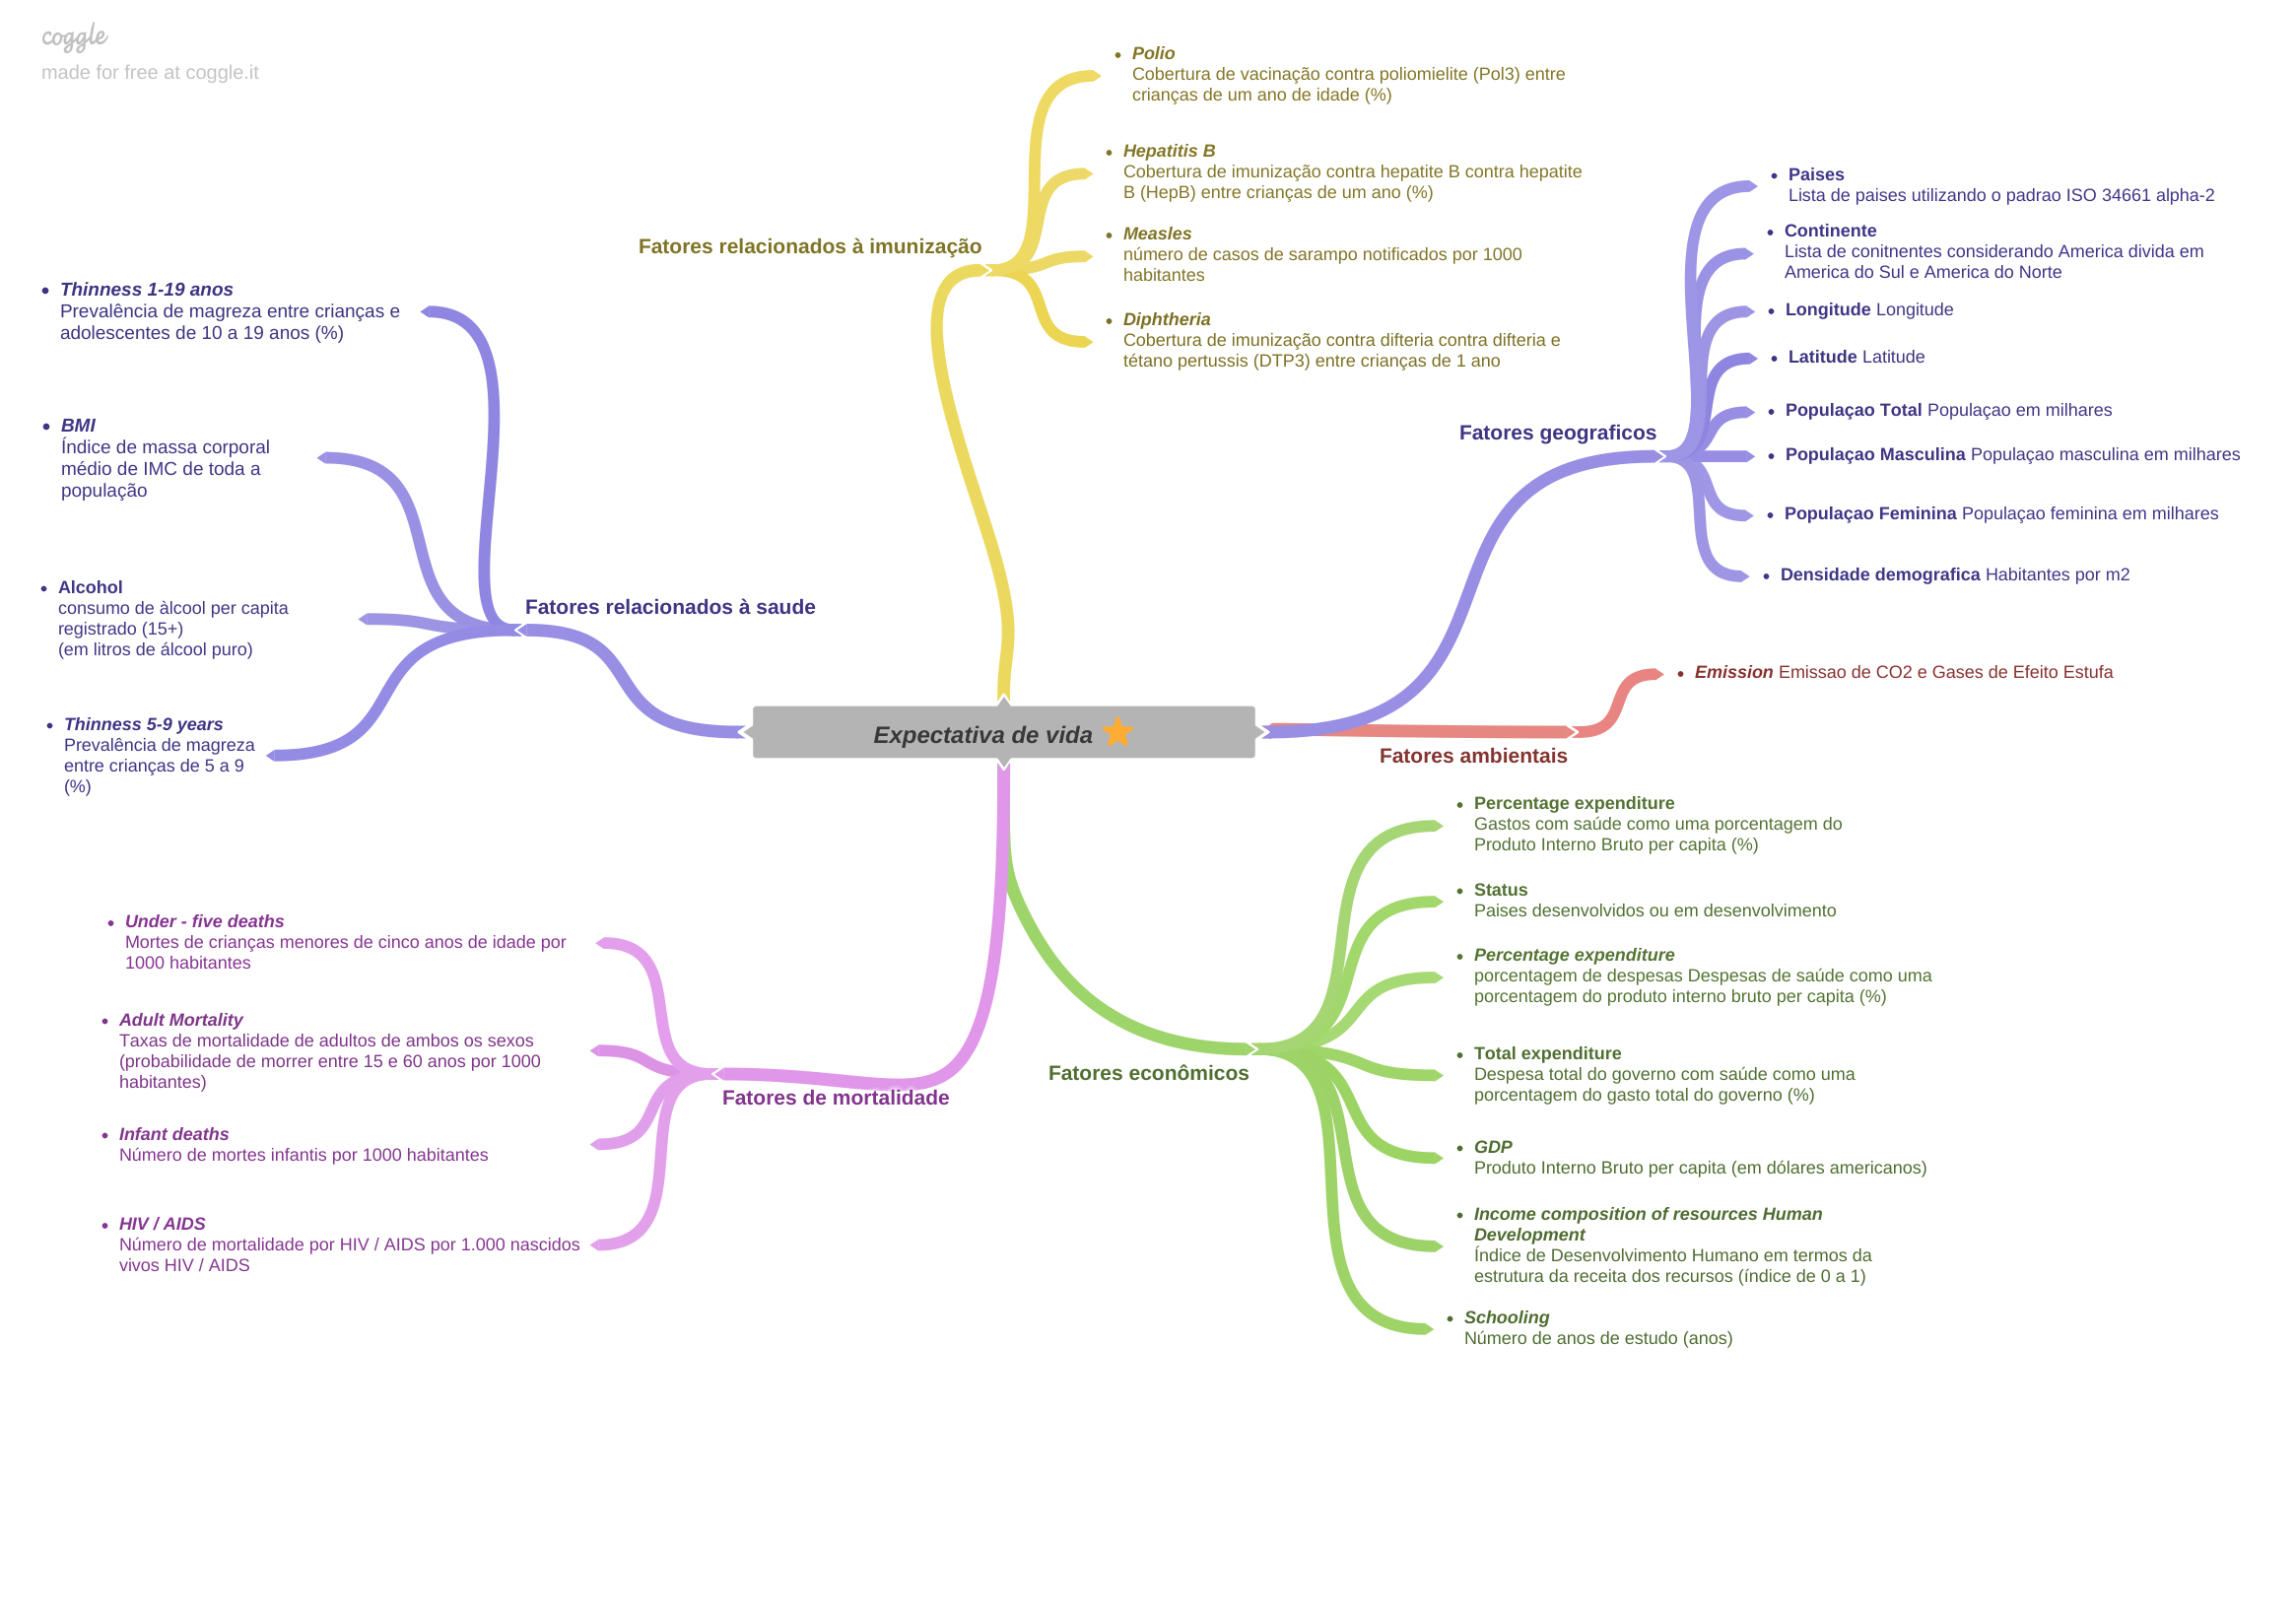

In [310]:
Image('../img/Expectativa_de_vida_star.png')

### Descriptive Statistics

In [311]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### Numerical Atributes

In [312]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes     min             max           range          mean  median            std  skew  kurtosis
0                              year 2000.00         2015.00           15.00       2007.52 2008.00           4.61 -0.01     -1.21
1                   life_expectancy   36.30           89.00           52.70         69.22     NaN           9.52 -0.64     -0.23
2                   adult_mortality    1.00          723.00          722.00        164.80     NaN         124.27  1.17      1.75
3                     infant_deaths    0.00         1800.00         1800.00         30.30    3.00         117.91  9.79    116.04
4                           alcohol    0.01           17.87           17.86          4.60     NaN           4.05  0.59     -0.80
5            percentage_expenditure    0.00        19479.91        19479.91        738.25   64.91        1987.58  4.65     26.57
6                       hepatitis_b    1.00           99.00           98.00         80.94     NaN          25.06 -1.93      2.77
7                           measles    0.00       212183.00       212183.00       2419.59   17.00       11465.32  9.44    114.86
8                               bmi    1.00           87.30           86.30         38.32     NaN          20.04 -0.22     -1.29
9                 under_five_deaths    0.00         2500.00         2500.00         42.04    4.00         160.42  9.50    109.75
10                            polio    3.00           99.00           96.00         82.55     NaN          23.42 -2.10      3.78
11                total_expenditure    0.37           17.60           17.23          5.94     NaN           2.50  0.62      1.16
12                       diphtheria    2.00           99.00           97.00         82.32     NaN          23.71 -2.07      3.56
13                         hiv_aids    0.10           50.60           50.50          1.74    0.10           5.08  5.40     34.89
14                              gdp    1.68       119172.74       119171.06       7483.16     NaN       14267.30  3.21     12.33
15              thinness_1_19_years    0.10           27.70           27.60          4.84     NaN           4.42  1.71      3.97
16               thinness_5_9_years    0.10           28.60           28.50          4.87     NaN           4.51  1.78      4.36
17  income_composition_of_resources    0.00            0.95            0.95          0.63     NaN           0.21 -1.14      1.39
18                        schooling    0.00           20.70           20.70         11.99     NaN           3.36 -0.60      0.89
19                         emission    0.00 389000000000.00 389000000000.00 6553095034.87     NaN 29181208055.13  9.45    103.59
20                         pop_male   35.71       722508.01       722472.30      18584.31     NaN       70463.98  8.34     73.22
21                       pop_female   40.30       684339.86       684299.56      18285.66     NaN       66363.16  8.19     71.49
22                        pop_total    1.61      1406847.87      1406846.26      36743.90     NaN      136593.19  8.28     72.65
23                          density    1.54        24764.43        24762.89        177.21     NaN         701.84 19.56    560.18
24                              lat  -41.50           64.98          106.48         18.42     NaN          24.39 -0.21     -0.65
25                             long -175.20          179.16          354.36         18.45     NaN          65.55 -0.07      0.26
26                      perc_female    0.23            0.54            0.31          0.50     NaN           0.03 -5.33     37.14
27                     emission_pop    0.00      1313605.50      1313605.50     183512.06     NaN      257204.18  1.98      3.94

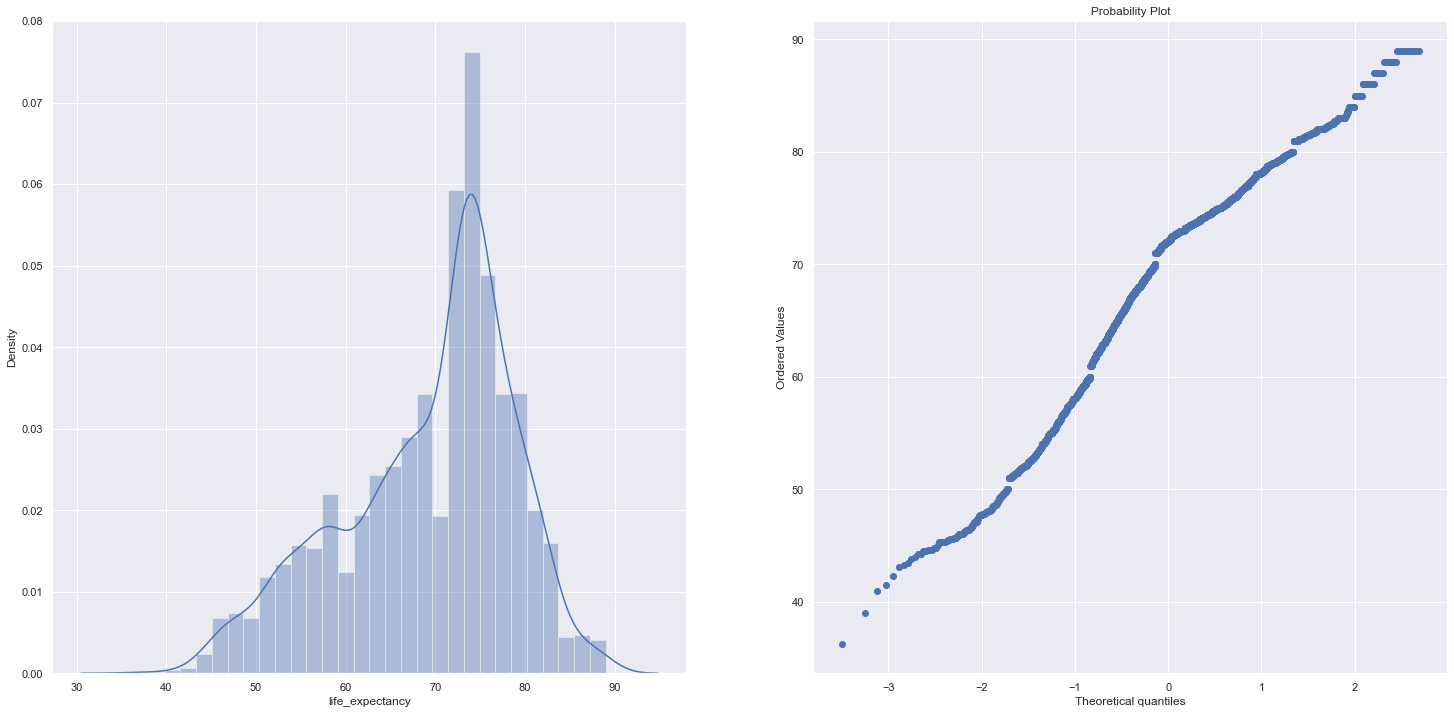

In [313]:
# Response variable
plt.subplot( 1, 2, 1)
sns.distplot(df1['life_expectancy']);

plt.subplot( 1, 2, 2 )
stats.probplot(df1['life_expectancy'],dist='norm',plot=pylab)
pylab.show()

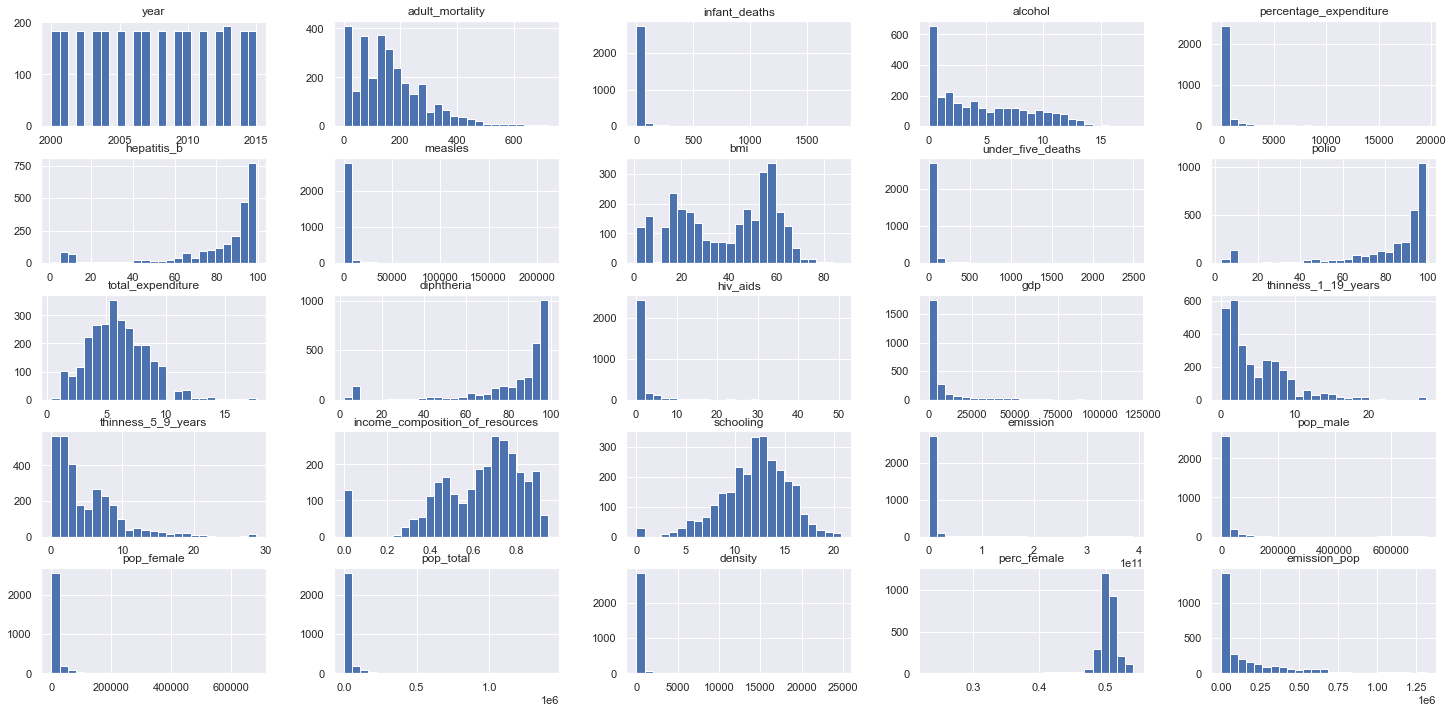

In [314]:
cols_drop = ['lat', 'long','life_expectancy']
num_attributes1=num_attributes.drop(cols_drop, axis=1 )
num_attributes1.hist( bins=25 );

#### Categorical Atributes

In [315]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

country      193
status         2
continent      6
code         188
dtype: int64

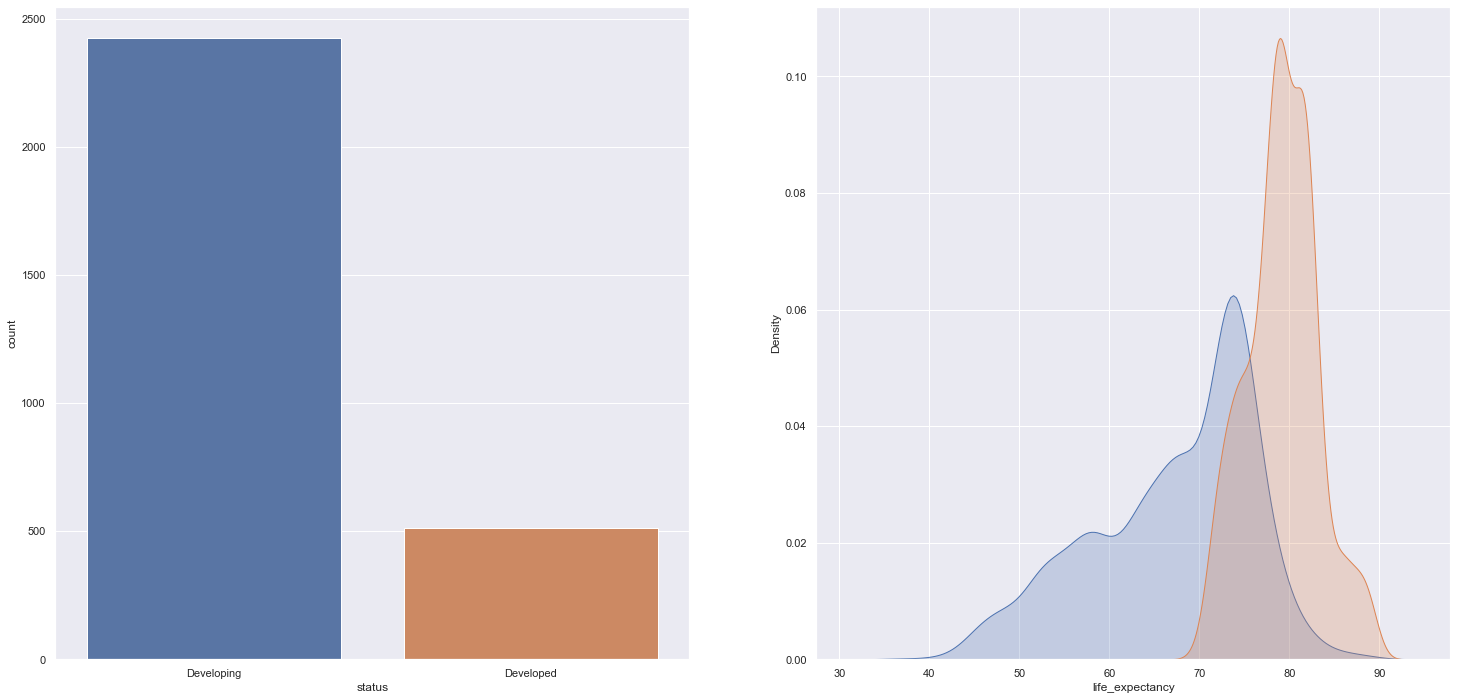

In [316]:
## Status
plt.subplot( 1, 2, 1 )

sns.countplot( df1['status'] )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df1[df1['status'] =='Developing']['life_expectancy'], label='status', shade=True )
sns.kdeplot( df1[df1['status'] =='Developed']['life_expectancy'], label='status', shade=True );

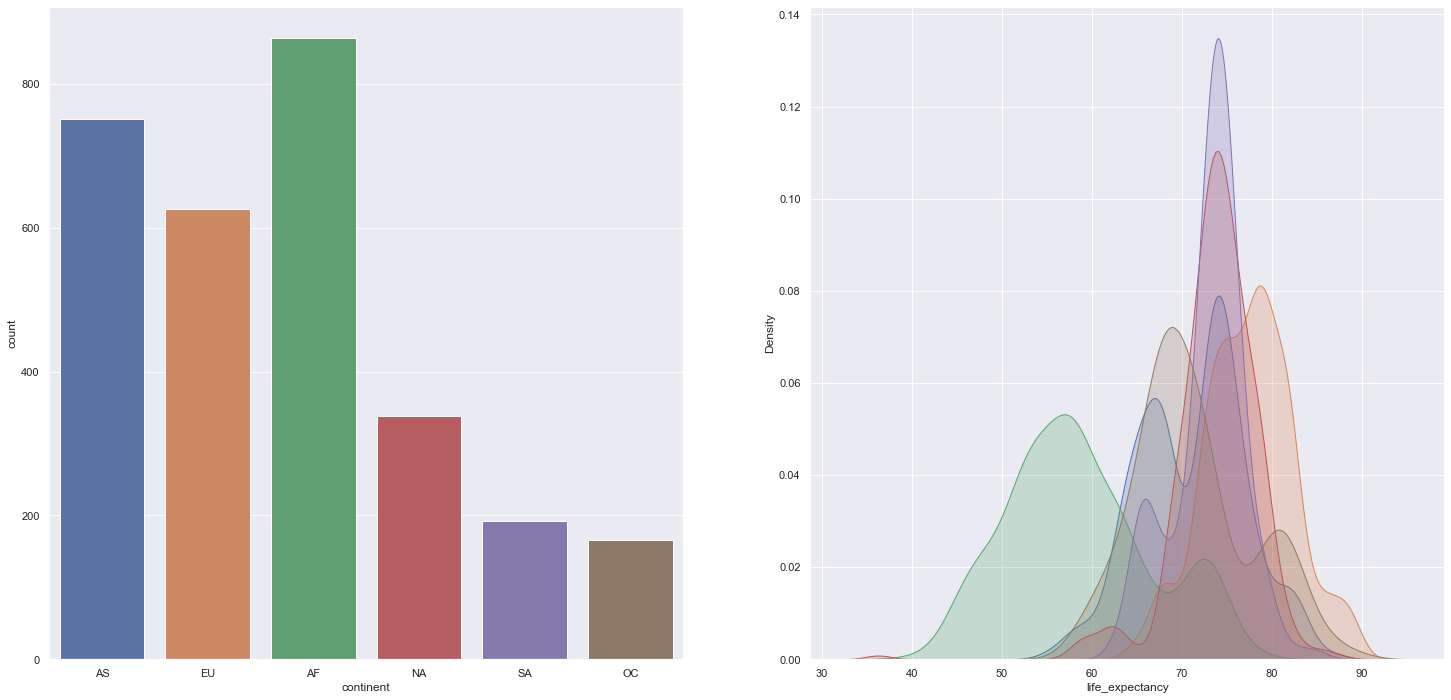

In [317]:
## continent
plt.subplot( 1, 2, 1 )
sns.countplot( df1['continent'] )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df1[df1['continent'] =='AS']['life_expectancy'], label='continent', shade=True )
sns.kdeplot( df1[df1['continent'] =='EU']['life_expectancy'], label='continent', shade=True )
sns.kdeplot( df1[df1['continent'] =='AF']['life_expectancy'], label='continent', shade=True )
sns.kdeplot( df1[df1['continent'] =='NA']['life_expectancy'], label='continent', shade=True )
sns.kdeplot( df1[df1['continent'] =='SA']['life_expectancy'], label='continent', shade=True )
sns.kdeplot( df1[df1['continent'] =='OC']['life_expectancy'], label='continent', shade=True );

### Missing values


In [318]:
# duplicate
df1.drop_duplicates()

print('not exist data duplicated' )

print('numero de linhas:{}'.format(df1.shape[0]))
print('numero de colunas:{}'.format(df1.shape[1]))


not exist data duplicated
numero de linhas:2938
numero de colunas:32


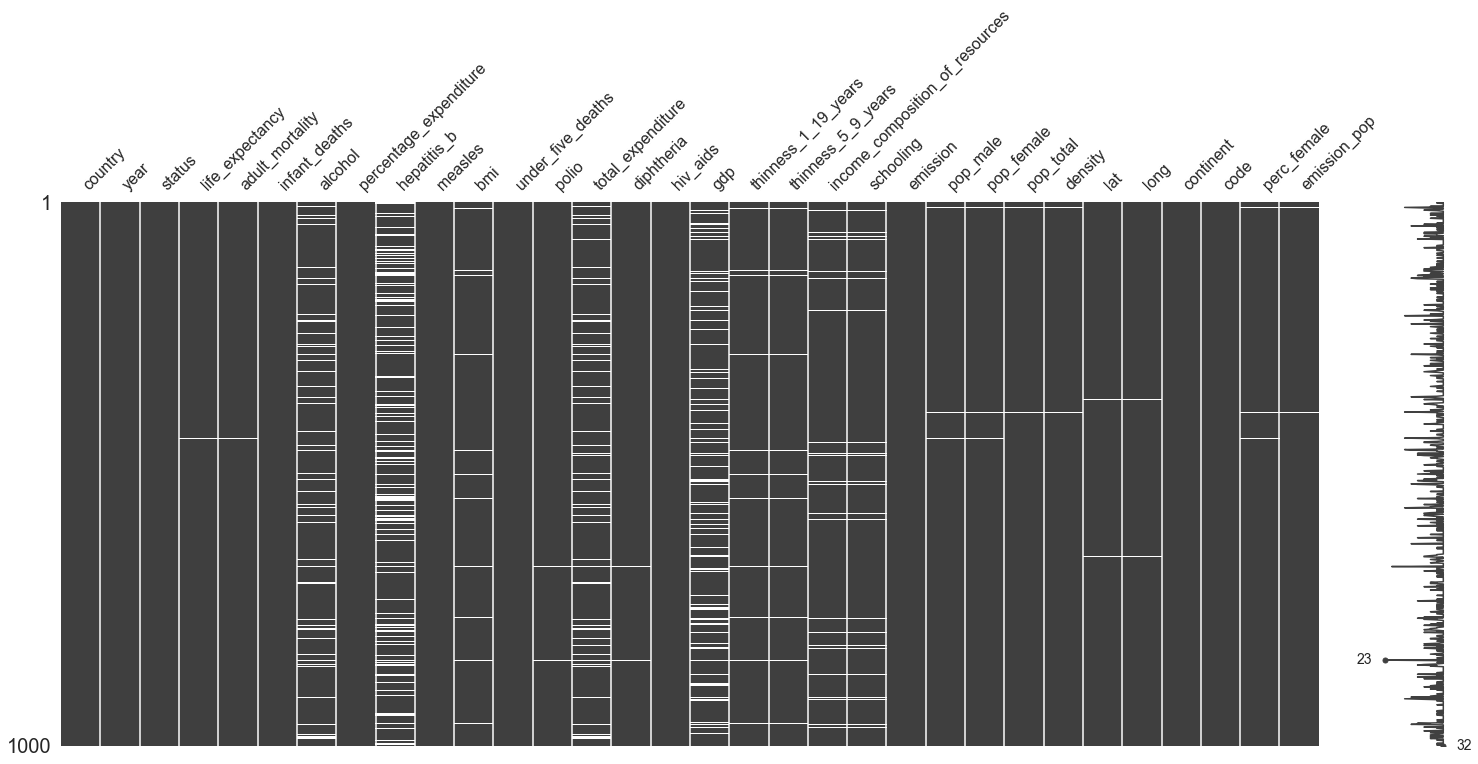

In [319]:
%matplotlib inline
msno.matrix(df1.sample(1000));

In [320]:
aux=df1.isna().sum().sort_values(ascending=False)
aux1=df1.isna().sum().sort_values(ascending=False)/df1.shape[0]*100

na=pd.concat([aux,aux1],axis=1)
na.columns=['NaN', 'NaN %']
na

NaN  NaN %
hepatitis_b                      553  18.82
gdp                              448  15.25
total_expenditure                226   7.69
alcohol                          194   6.60
income_composition_of_resources  167   5.68
schooling                        163   5.55
thinness_1_19_years               34   1.16
bmi                               34   1.16
thinness_5_9_years                34   1.16
perc_female                       26   0.88
pop_female                        26   0.88
pop_male                          26   0.88
polio                             19   0.65
diphtheria                        19   0.65
long                              18   0.61
emission_pop                      18   0.61
pop_total                         16   0.54
density                           16   0.54
lat                               16   0.54
adult_mortality                   10   0.34
life_expectancy                   10   0.34
emission                           2   0.07
year                               0   0.00
hiv_aids                           0   0.00
under_five_deaths                  0   0.00
measles                            0   0.00
percentage_expenditure             0   0.00
infant_deaths                      0   0.00
continent                          0   0.00
code                               0   0.00
status                             0   0.00
country                            0   0.00

#### Bias  gdp

In [321]:
df1=df1.drop(['gdp'], axis=1) # drop original collumn 

df_gdp=pd.read_excel('../Datasets/GDPPC-USD-countries.xls',header=2)# New set Dataframe with standard country names 
df_gdp=df_gdp[['Country',2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015]]
df_gdp=df_gdp.melt(id_vars=['Country'])  # stacks the data with granularity in the country
df_gdp.columns=['country','year','gdp']
    

In [322]:
# Checking the country names

countryISO=df['country'].unique()

gdpcountry=df_gdp['country'].unique()

(set(countryISO) ^ set(gdpcountry))-set(countryISO)

(set(countryISO) ^ set(gdpcountry))-set(gdpcountry)

{"Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 "Lao People's Democratic Republic",
 'Micronesia (Federated States of)',
 'Niue',
 'Saint Vincent and the Grenadines',
 'Swaziland',
 'The former Yugoslav republic of Macedonia',
 'United Kingdom of Great Britain and Northern Ireland',
 'United Republic of Tanzania',
 'United States of America'}

In [323]:
countryISO_unmatch=["Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 "Lao People's Democratic Republic",
 'Micronesia (Federated States of)',
 'Saint Vincent and the Grenadines',
 'The former Yugoslav republic of Macedonia',
 'United Kingdom of Great Britain and Northern Ireland',
 'United Republic of Tanzania',
 'United States of America']

countrygdp_unmatch=[ 
 'D.P.R. of Korea',
 'D.R. of the Congo',
 "Lao People's DR",
 'Micronesia (FS of)',
 'St. Vincent and the Grenadines',
 'North Macedonia',
 'United Kingdom',
 'U.R. of Tanzania: Mainland',
 'United States',
]


dicgdp = dict(zip(countrygdp_unmatch,countryISO_unmatch))
df_gdp['country']=df_gdp['country'].replace(dicgdp)


df_gdp['year']=df_gdp['year'].astype(str)
df_gdp['year'] = pd.to_datetime( df_gdp['year'] ).dt.strftime('%Y')
df1['year']=df1['year'].astype(str)
df1['year'] = pd.to_datetime( df1['year'] ).dt.strftime('%Y')


df1=pd.merge(df1,df_gdp,how='left',on=['country','year'])

df1.head()

country  year      status  life_expectancy  adult_mortality  infant_deaths  alcohol  percentage_expenditure  hepatitis_b  measles   bmi  under_five_deaths  polio  total_expenditure  diphtheria  hiv_aids  thinness_1_19_years  thinness_5_9_years  income_composition_of_resources  schooling     emission  pop_male  pop_female  pop_total  density   lat  long continent code  perc_female  emission_pop    gdp
0  Afghanistan  2015  Developing            65.00           263.00             62     0.01                   71.28        65.00     1154 19.10                 83   6.00               8.16       65.00      0.10                17.20               17.30                             0.48      10.10 153230277.00  17686.17    16727.44   34413.60    52.71 33.77 66.24        AS   AF         0.49       4452.61 543.77
1  Afghanistan  2014  Developing            59.90           271.00             64     0.01                   73.52        62.00      492 18.60                 86  58.00               8.18       62.00      0.10                17.50               17.50                             0.48      10.00 143122849.00  17138.80    16232.00   33370.80    51.12 33.77 66.24        AS   AF         0.49       4288.86 585.86
2  Afghanistan  2013  Developing            59.90           268.00             66     0.01                   73.22        64.00      430 18.10                 89  62.00               8.13       64.00      0.10                17.70               17.70                             0.47       9.90 133333663.00  16554.28    15715.31   32269.59    49.43 33.77 66.24        AS   AF         0.49       4131.87 608.06
3  Afghanistan  2012  Developing            59.50           272.00             69     0.01                   78.18        67.00     2787 17.60                 93  67.00               8.52       67.00      0.10                17.90               18.00                             0.46       9.80 123333249.00  15964.87    15196.50   31161.38    47.73 33.77 66.24        AS   AF         0.49       3957.89 614.11
4  Afghanistan  2011  Developing            59.20           275.00             71     0.01                    7.10        68.00     3013 17.20                 97  68.00               7.87       68.00      0.10                18.20               18.20                             0.45       9.50 112591192.00  15415.36    14702.05   30117.41    46.13 33.77 66.24        AS   AF         0.49       3738.41 576.10

#### NaN com algoritmo KNN

In [324]:
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform",metric='nan_euclidean')
df1['hepatitis_b'] = knn_imputer.fit_transform(df1[['hepatitis_b']])
df1['alcohol'] = knn_imputer.fit_transform(df1[['alcohol']])
df1['total_expenditure'] = knn_imputer.fit_transform(df1[['total_expenditure']])
df1['income_composition_of_resources'] = knn_imputer.fit_transform(df1[['income_composition_of_resources']])
df1['schooling'] = knn_imputer.fit_transform(df1[['schooling']])

#### NaN lat long

In [325]:
null_cols_code=df1.loc[df1['long'].isnull(),'country'].unique()
null_cols_code

array(['Brunei Darussalam', 'Sierra Leone',
       'The former Yugoslav republic of Macedonia'], dtype=object)

In [326]:
lat=[-16.2837065,32.4207423,41.6137143]
lon=[-63.5493965,53.6830157,21.743258]

for i in range(len(null_cols_code)):
    for j in range(len(df1)):
        if null_cols_code[i] == df1.loc[j,'country'] :
            df1.loc[j,'lat']=lat[i]
            df1.loc[j,'long']=lon[i]

#### Eliminar NaN

In [327]:
df1.isna().sum().sort_values(ascending=False)

thinness_1_19_years                34
bmi                                34
thinness_5_9_years                 34
gdp                                33
perc_female                        26
pop_female                         26
pop_male                           26
polio                              19
diphtheria                         19
emission_pop                       18
density                            16
pop_total                          16
adult_mortality                    10
life_expectancy                    10
emission                            2
code                                0
continent                           0
long                                0
lat                                 0
income_composition_of_resources     0
schooling                           0
infant_deaths                       0
status                              0
year                                0
hiv_aids                            0
total_expenditure                   0
under_five_d

In [328]:
## temporariamente eliminar population e gdp

df1= df1.dropna(subset=['gdp','polio','bmi','life_expectancy'])

In [329]:
df1.isna().sum().sort_values(ascending=False)

country                            0
year                               0
emission_pop                       0
perc_female                        0
code                               0
continent                          0
long                               0
lat                                0
density                            0
pop_total                          0
pop_female                         0
pop_male                           0
emission                           0
schooling                          0
income_composition_of_resources    0
thinness_5_9_years                 0
thinness_1_19_years                0
hiv_aids                           0
diphtheria                         0
total_expenditure                  0
polio                              0
under_five_deaths                  0
bmi                                0
measles                            0
hepatitis_b                        0
percentage_expenditure             0
alcohol                            0
i

In [330]:
print('novo numero de linhas:{}'.format(df1.shape[0]))
print('novo numero de colunas:{}'.format(df1.shape[1]))

novo numero de linhas:2872
novo numero de colunas:32


In [331]:
# normality Test
columns=df1.columns
for i in columns:
    print ([i])
    stat,p= stats.kstest(df1['life_expectancy'], 'norm')    
    print ("Statistics", stat, "p-value", p)
    if p < 0.05:  
        print("Shapiro-Wilk Test - Probably **NOT** Gaussian")
    else:
        print("Shapiro-Wilk Test - Probably Gaussian")

['country']
Statistics 1.0 p-value 0.0
Shapiro-Wilk Test - Probably **NOT** Gaussian
['year']
Statistics 1.0 p-value 0.0
Shapiro-Wilk Test - Probably **NOT** Gaussian
['status']
Statistics 1.0 p-value 0.0
Shapiro-Wilk Test - Probably **NOT** Gaussian
['life_expectancy']
Statistics 1.0 p-value 0.0
Shapiro-Wilk Test - Probably **NOT** Gaussian
['adult_mortality']
Statistics 1.0 p-value 0.0
Shapiro-Wilk Test - Probably **NOT** Gaussian
['infant_deaths']
Statistics 1.0 p-value 0.0
Shapiro-Wilk Test - Probably **NOT** Gaussian
['alcohol']
Statistics 1.0 p-value 0.0
Shapiro-Wilk Test - Probably **NOT** Gaussian
['percentage_expenditure']
Statistics 1.0 p-value 0.0
Shapiro-Wilk Test - Probably **NOT** Gaussian
['hepatitis_b']
Statistics 1.0 p-value 0.0
Shapiro-Wilk Test - Probably **NOT** Gaussian
['measles']
Statistics 1.0 p-value 0.0
Shapiro-Wilk Test - Probably **NOT** Gaussian
['bmi']
Statistics 1.0 p-value 0.0
Shapiro-Wilk Test - Probably **NOT** Gaussian
['under_five_deaths']
Statistics

## Exploratory Data Analysis


In [332]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [333]:
df2=df1.copy()

### **H1** - Países densamente povoados ou altamaente populosos tendem a ter menor expectativa de vida?

In [334]:
map=df2[['continent','status','country','lat','long','pop_total','density','life_expectancy']].groupby(['continent','country','status']).mean().reset_index()
map.head()

continent       country      status    lat  long  pop_total  density  life_expectancy
0        AF       Algeria  Developing  28.00  3.00   34821.37    14.62            73.62
1        AF        Angola  Developing -11.88 17.57   21622.86    17.34            49.02
2        AF         Benin  Developing   9.53  2.26    8628.81    76.52            57.57
3        AF      Botswana  Developing -23.17 24.59    1888.51     3.33            56.05
4        AF  Burkina Faso  Developing  12.08 -1.69   14618.29    53.43            55.64

In [335]:
    fig=px.scatter_mapbox(map,
                          hover_name='country',
                          hover_data=["life_expectancy", "density",'status'],
                          lat='lat',
                          lon='long',
                          size='density',
                          color='life_expectancy',
                          color_continuous_scale=px.colors.cyclical.IceFire_r,
                          size_max=60,
                          zoom=1)

    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(height=400, margin={'r':0,'l':0,'t':0,'b':0})
    fig.show()

In [336]:
fig=px.scatter_mapbox(map,
                          hover_name='country',
                          hover_data=["life_expectancy", "density",'status'],
                          lat='lat',
                          lon='long',
                          size='pop_total',
                          color='life_expectancy',
                          color_continuous_scale=px.colors.cyclical.IceFire_r,
                          size_max=60,
                          zoom=1)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(height=400, margin={'r':0,'l':0,'t':0,'b':0})
fig.show()

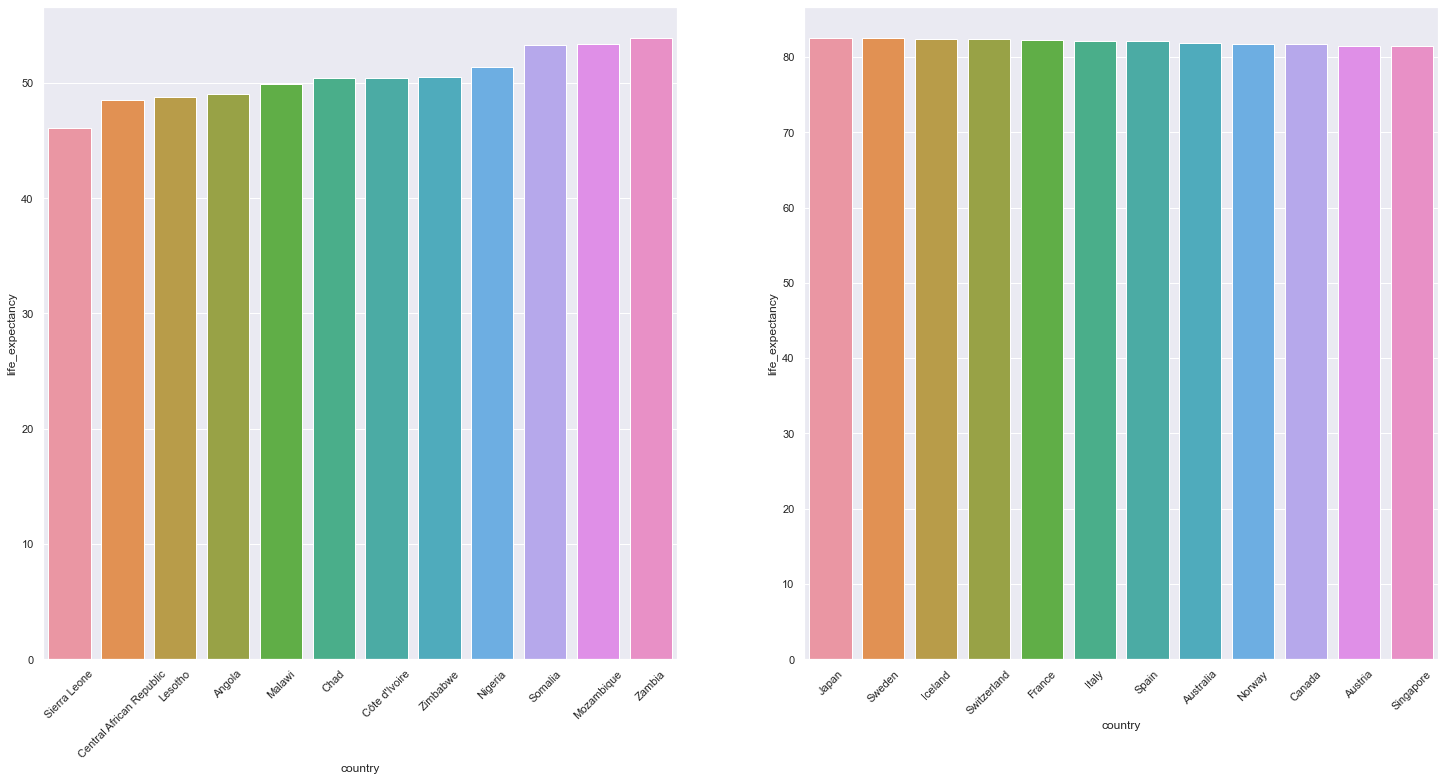

In [337]:
## continent
plt.subplot( 1, 2, 2)
a=df2[['country','life_expectancy']].groupby('country').mean().sort_values(ascending=False,by='life_expectancy').reset_index()
a=a.head(12)
sns.barplot(x='country',y='life_expectancy',data=a);
plt.xticks(rotation=45);

plt.subplot( 1, 2, 1 )
b=df2[['country','life_expectancy']].groupby('country').mean().sort_values(ascending=True,by='life_expectancy').reset_index()
b=b.head(12)
sns.barplot(x='country',y='life_expectancy',data=b);
plt.xticks(rotation=45);


###  **H2**- Como è a variaçao da expectativa de vida dentro dos continentes


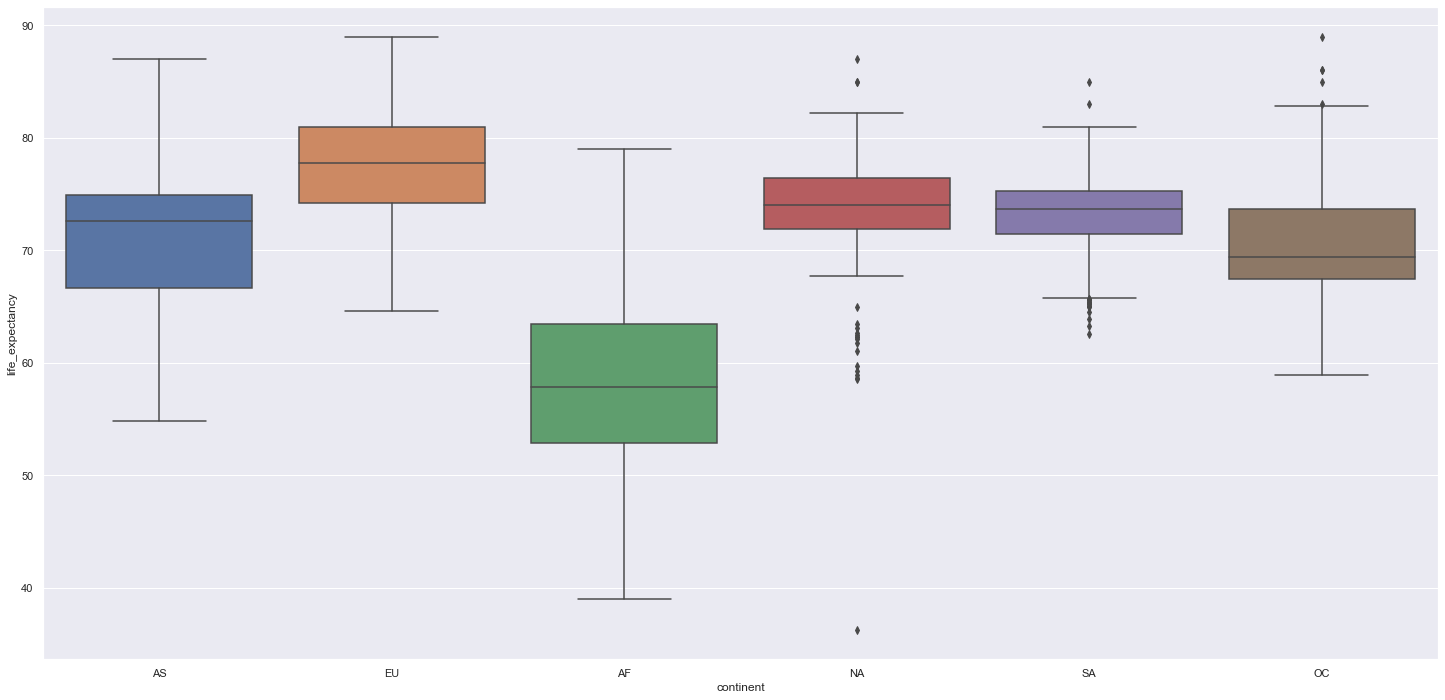

In [338]:
aux = df2[['continent','country','life_expectancy','year']]

#life_expectancy per continent
sns.boxplot( x='continent', y='life_expectancy',data=df2);


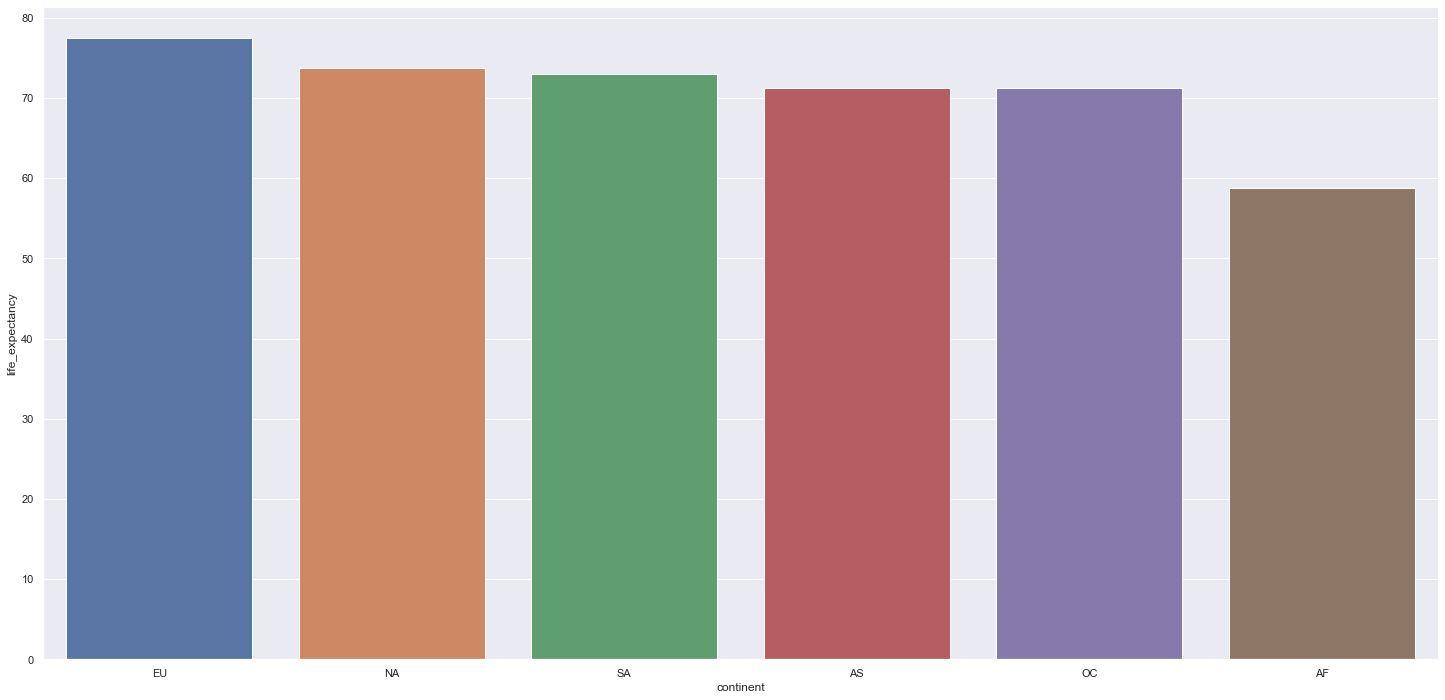

In [339]:
## continent

a=df2[['continent','life_expectancy']].groupby('continent').mean().sort_values(ascending=False,by='life_expectancy').reset_index()
a=a.head(12)
sns.barplot(x='continent',y='life_expectancy',data=a);

### **H3** - Como foi a evolucaçao da expectativa de vida ao longo dos anos

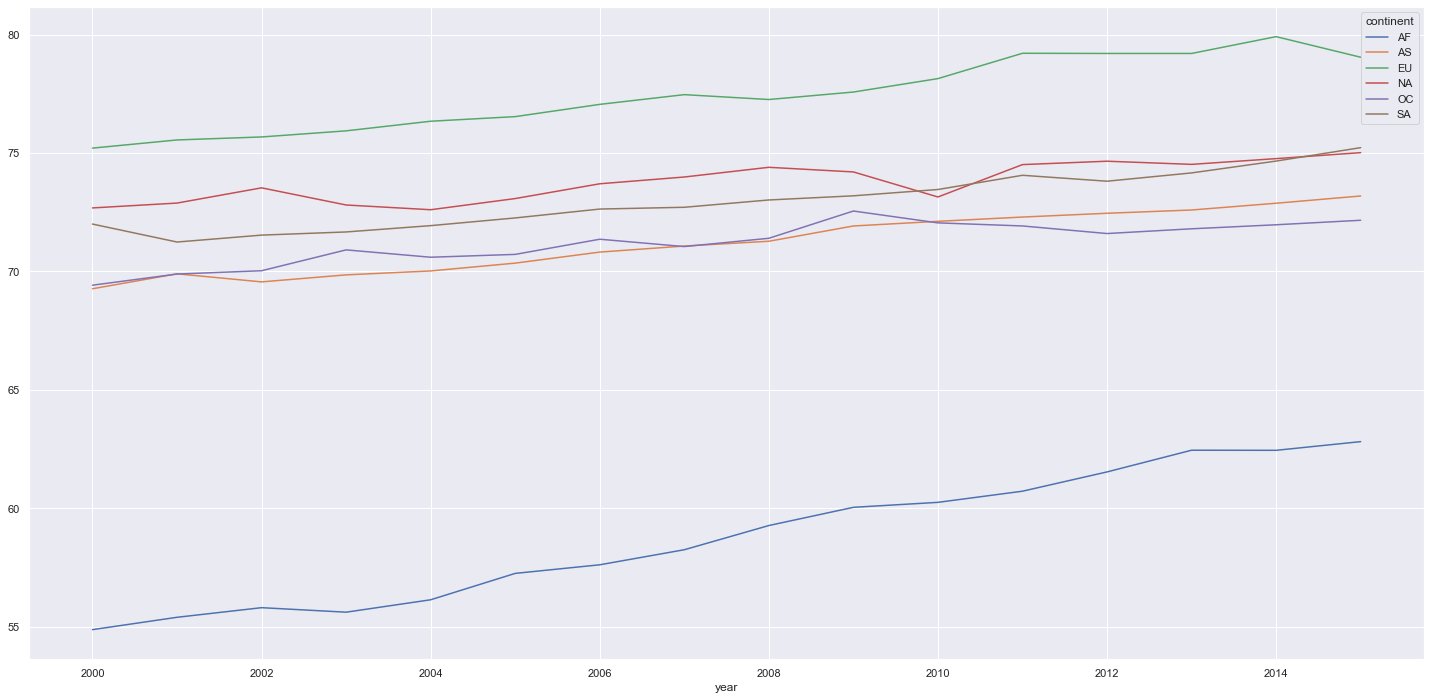

In [340]:
#life_expectancy mean per year
aux1 = df2[['year','continent','life_expectancy']].groupby(['continent','year']).mean().reset_index()
aux1.pivot(index='year',columns='continent',values='life_expectancy').plot();

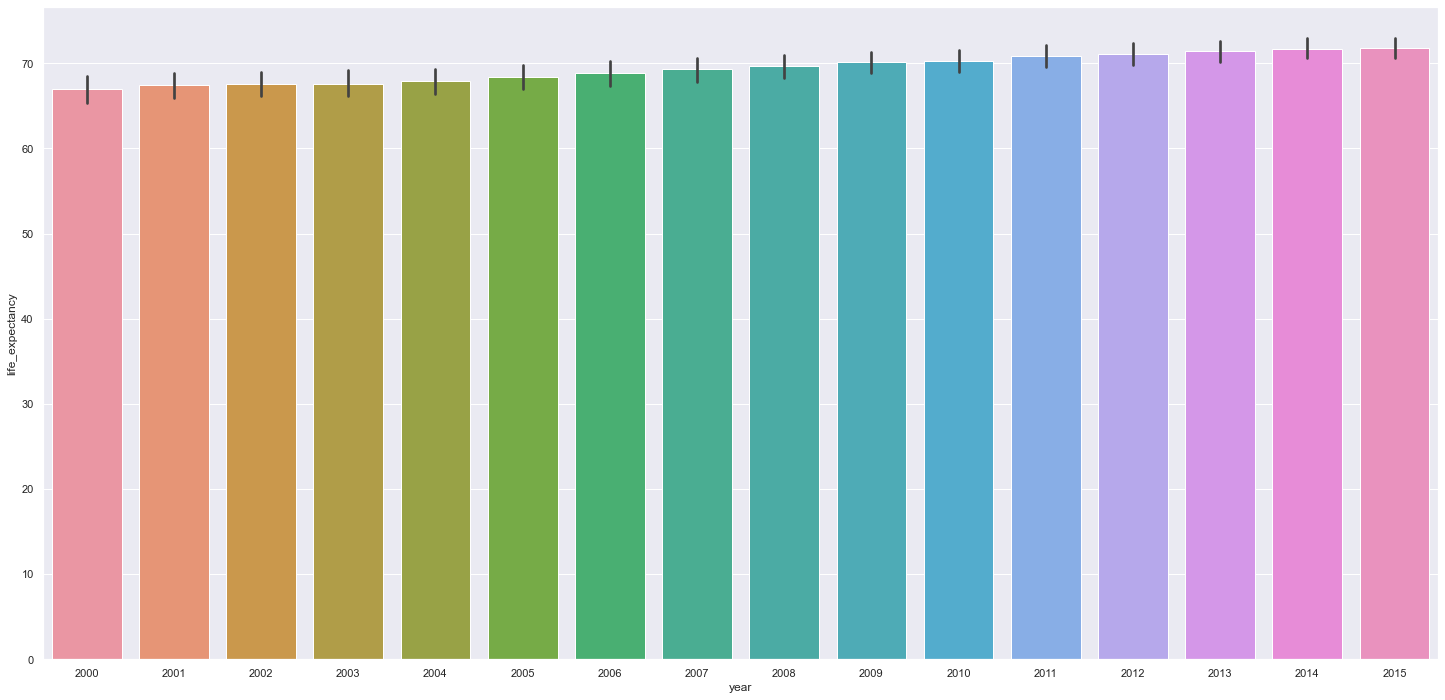

In [341]:
#life_expectancy mean per year
aux1 = df2[['year','country','life_expectancy']].groupby(['country','year']).mean().reset_index()
sns.barplot(x='year',y='life_expectancy',data=aux1);


###  **H4**  - Como as taxas de mortalidade de bebês e adultos afetam a expectativa de vida?


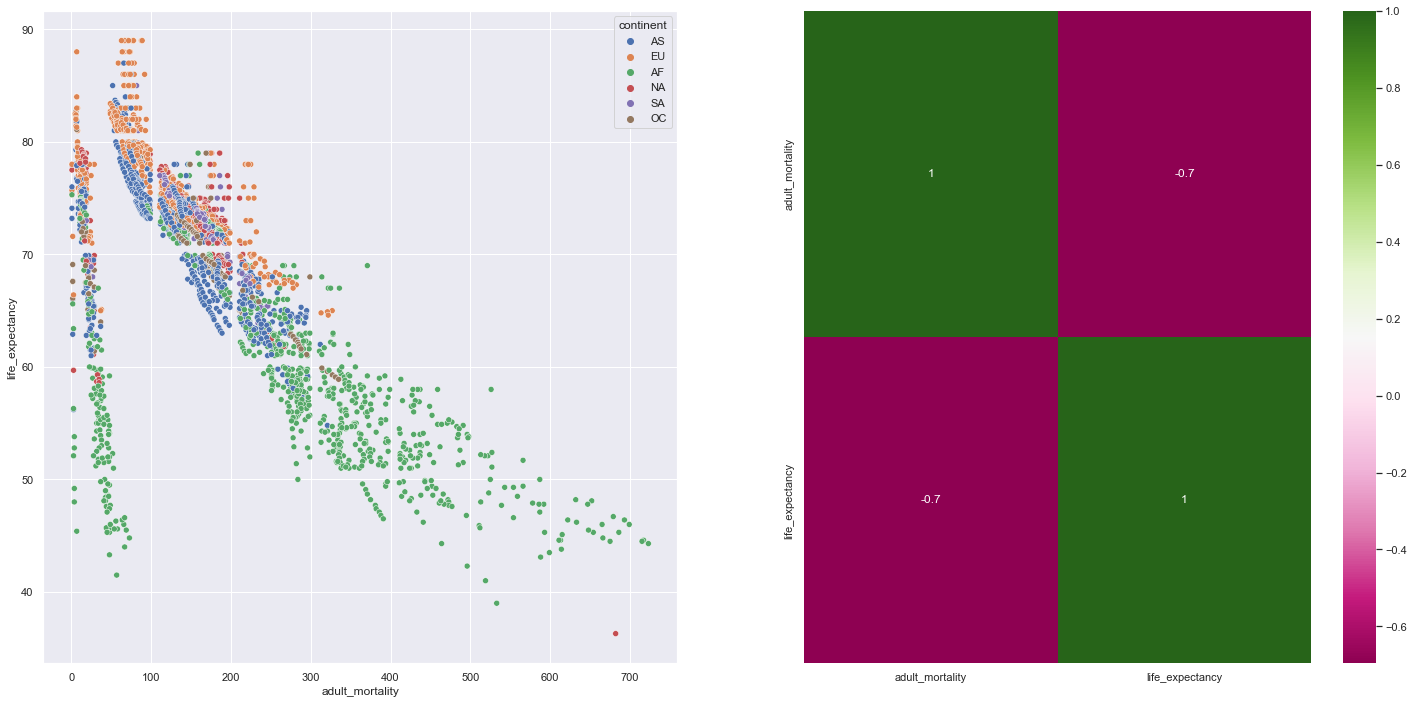

In [342]:
aux2 = df2[['adult_mortality','life_expectancy','continent']]

plt.subplot( 1, 2, 1 )
sns.scatterplot(x='adult_mortality',y='life_expectancy',hue='continent',data=df2)

plt.subplot( 1, 2, 2 )
sns.heatmap(aux2.corr(method='pearson'),annot=True,cmap="PiYG");

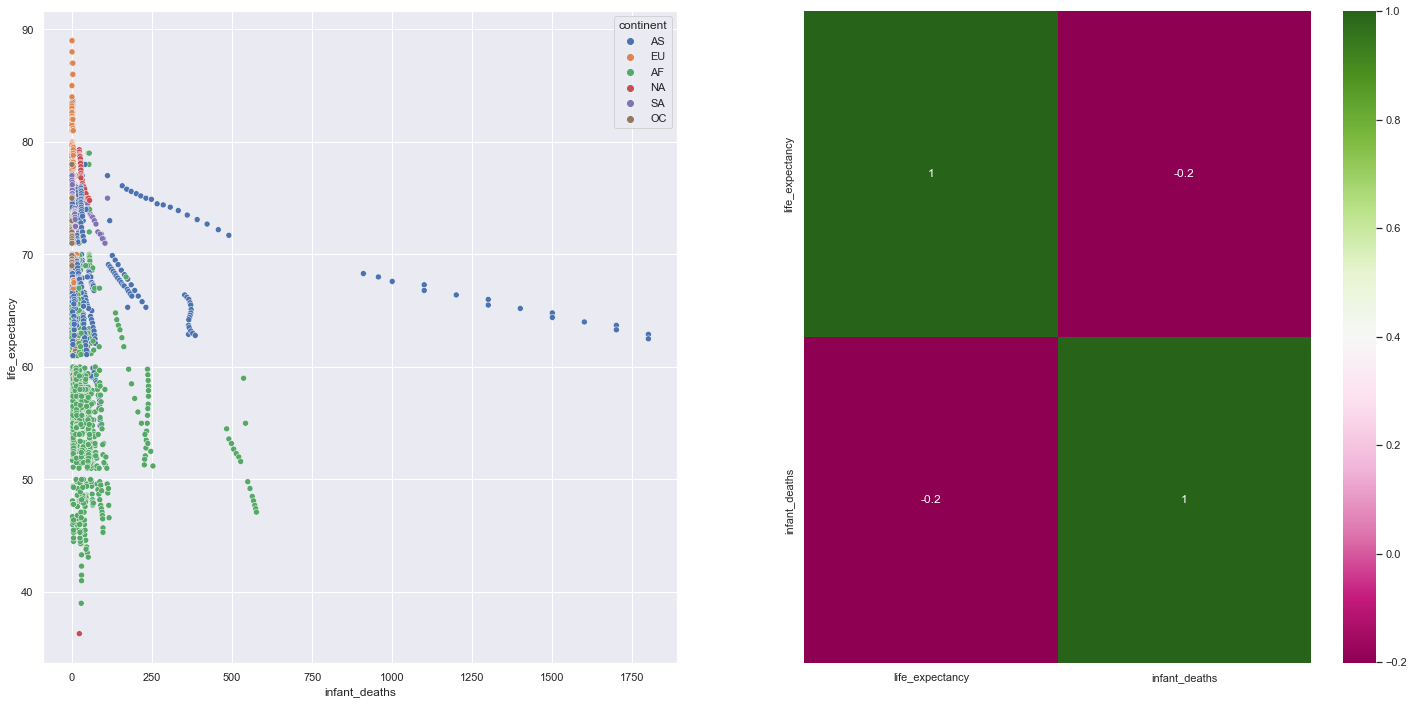

In [343]:
aux3 = df2[['life_expectancy','infant_deaths','continent']]

plt.subplot( 1, 2, 1 )
sns.scatterplot(x='infant_deaths',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 1, 2, 2 )
sns.heatmap(aux3.corr(method='pearson'),annot=True,cmap="PiYG");


### **H5**  - Qual é o impacto da escolaridade na expectativa de vida dos humanos?


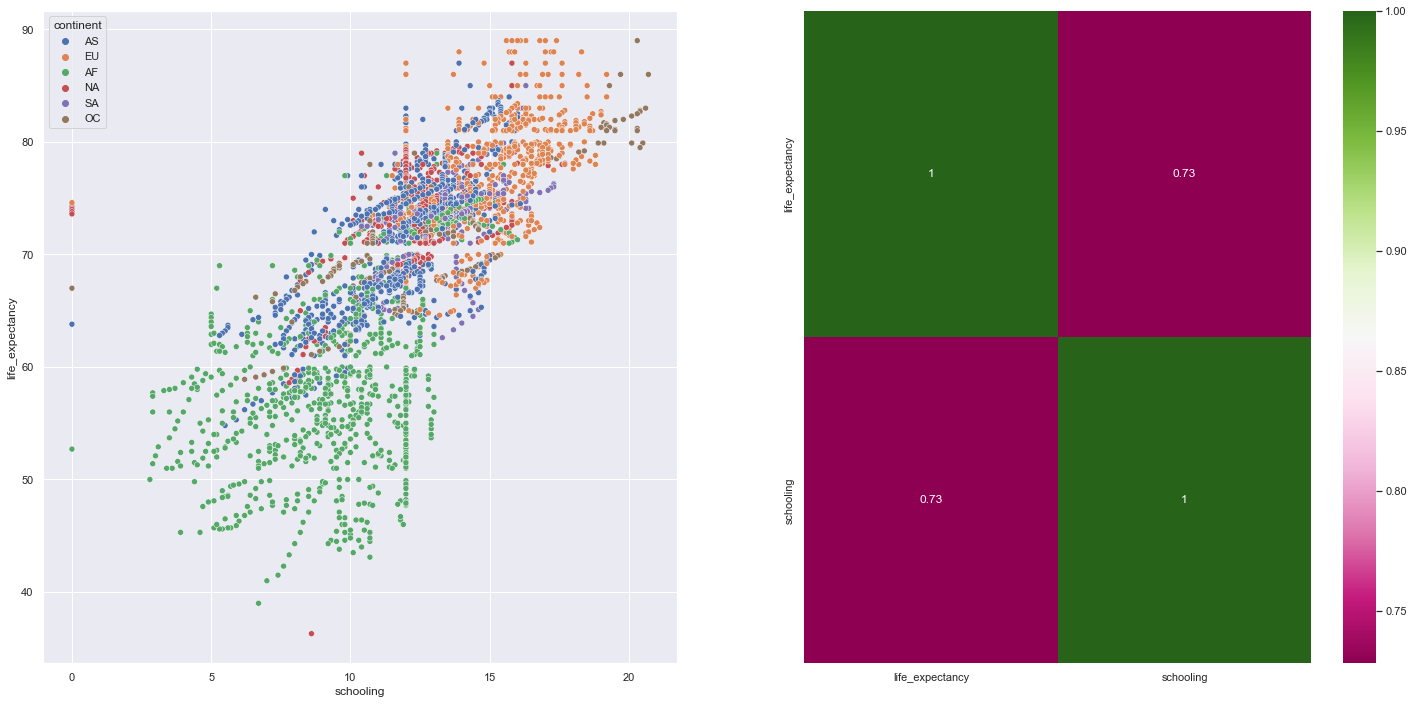

In [344]:
aux4 = df2[['life_expectancy','schooling','continent']]

plt.subplot( 1, 2, 1 )
sns.scatterplot(x='schooling',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 1, 2, 2 )
sns.heatmap(aux4.corr(method='pearson'),annot=True,cmap="PiYG");


### **H6**  - A expectativa de vida tem uma relação positiva ou negativa com o consumo de álcool?


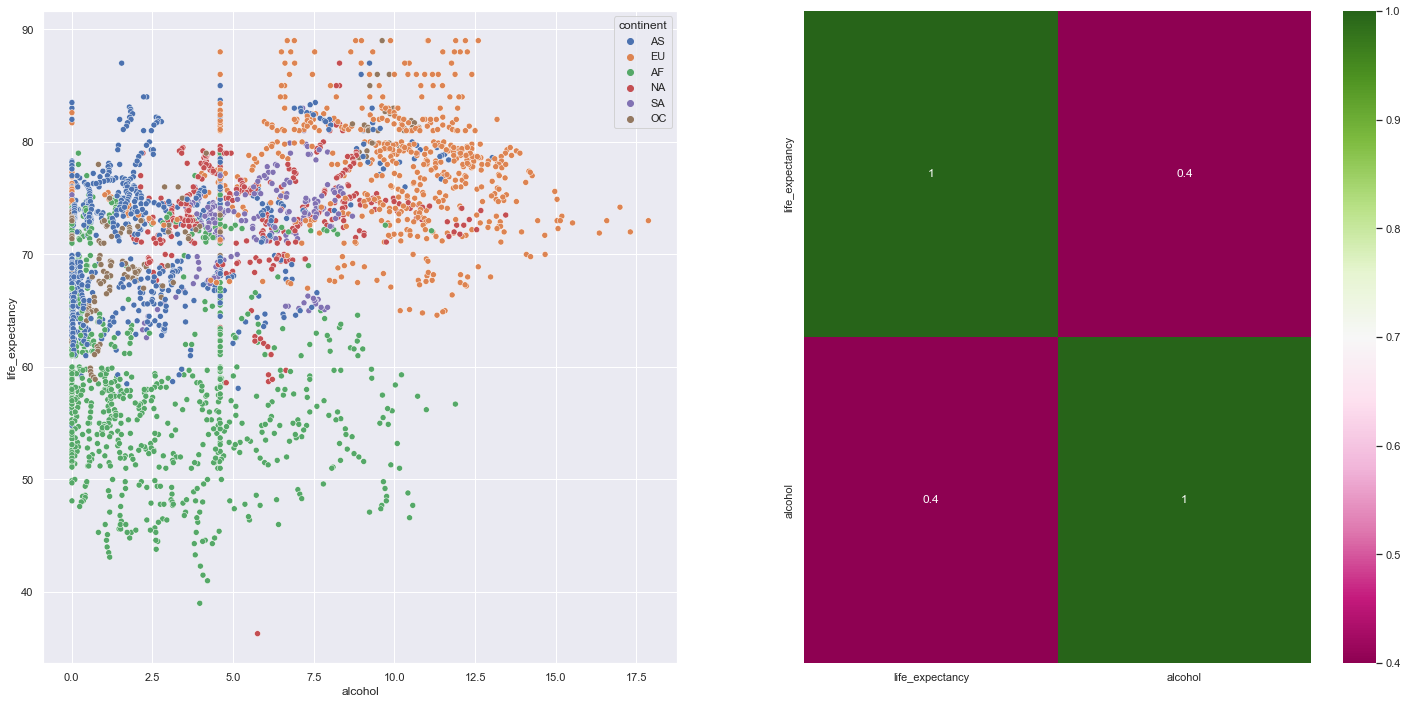

In [345]:
aux5 = df2[['life_expectancy','alcohol','continent']]

plt.subplot( 1, 2, 1 )
sns.scatterplot(x='alcohol',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 1, 2, 2 )
sns.heatmap(aux5.corr(method='pearson'),annot=True,cmap="PiYG");


### **H7**  - Paises mais inquinados representam uma expectativa de vida menor?

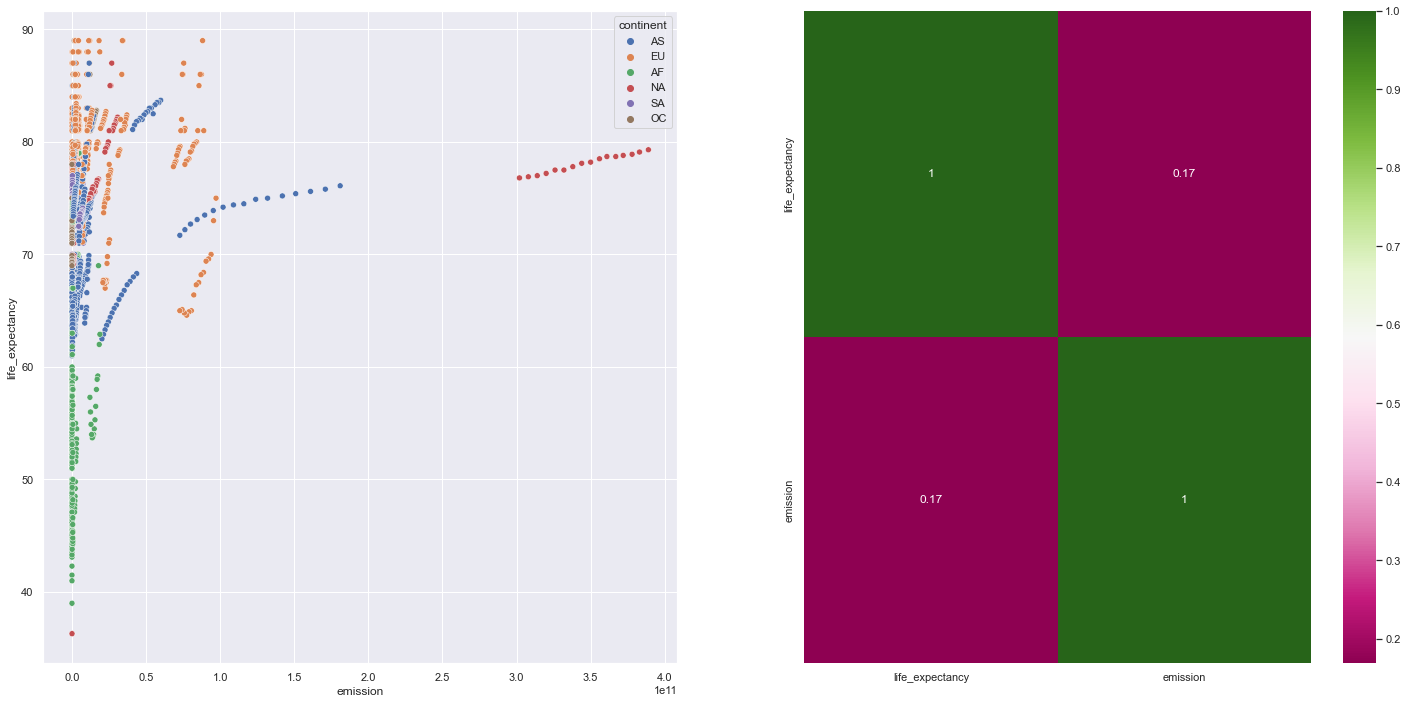

In [346]:
aux6 = df2[['life_expectancy','emission','continent']]

plt.subplot( 1, 2, 1 )
sns.scatterplot(x='emission',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 1, 2, 2 )
sns.heatmap(aux6.corr(method='pearson'),annot=True,cmap="PiYG");


### **H8**  - Qual é o impacto da cobertura de imunização na expectativa de vida?

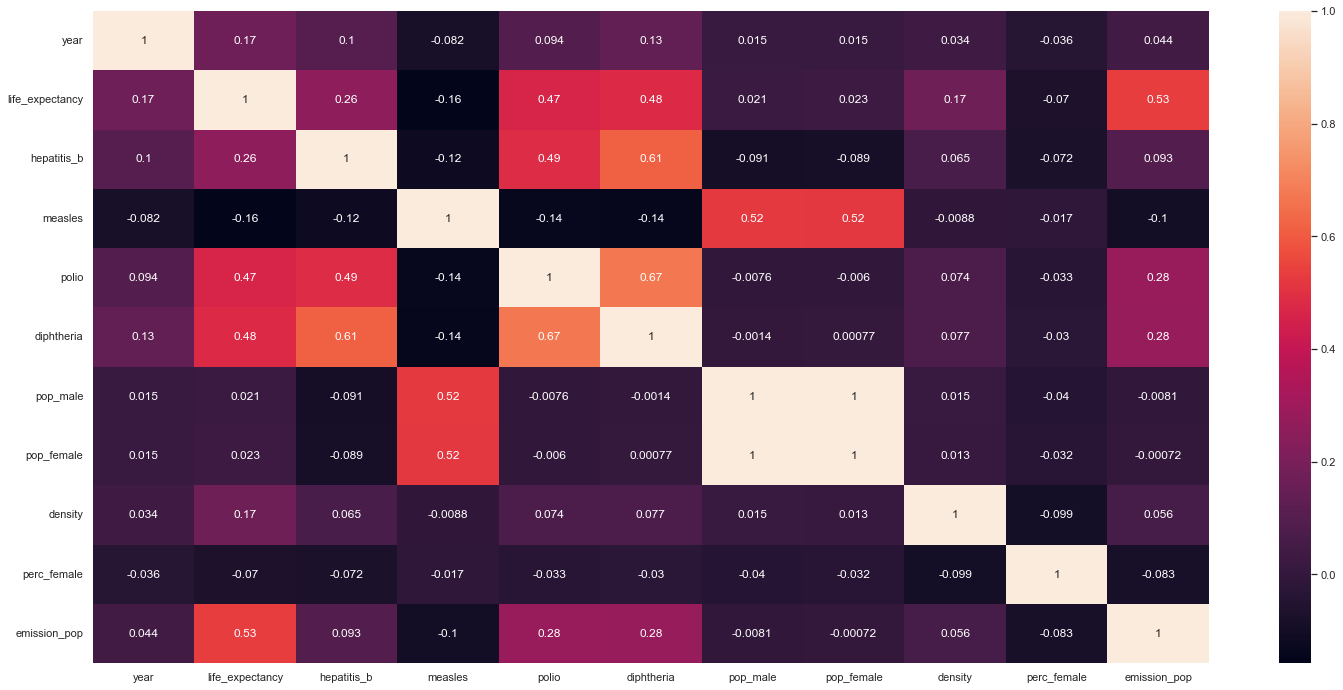

In [347]:
cols_drop = ['adult_mortality', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'bmi',
       'under_five_deaths', 'total_expenditure', 
       'hiv_aids', 'gdp', 'pop_total', 'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling',
       'emission', 'lat', 'long']

num_attributes2=num_attributes.drop(cols_drop, axis=1 )
correlation = num_attributes2.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

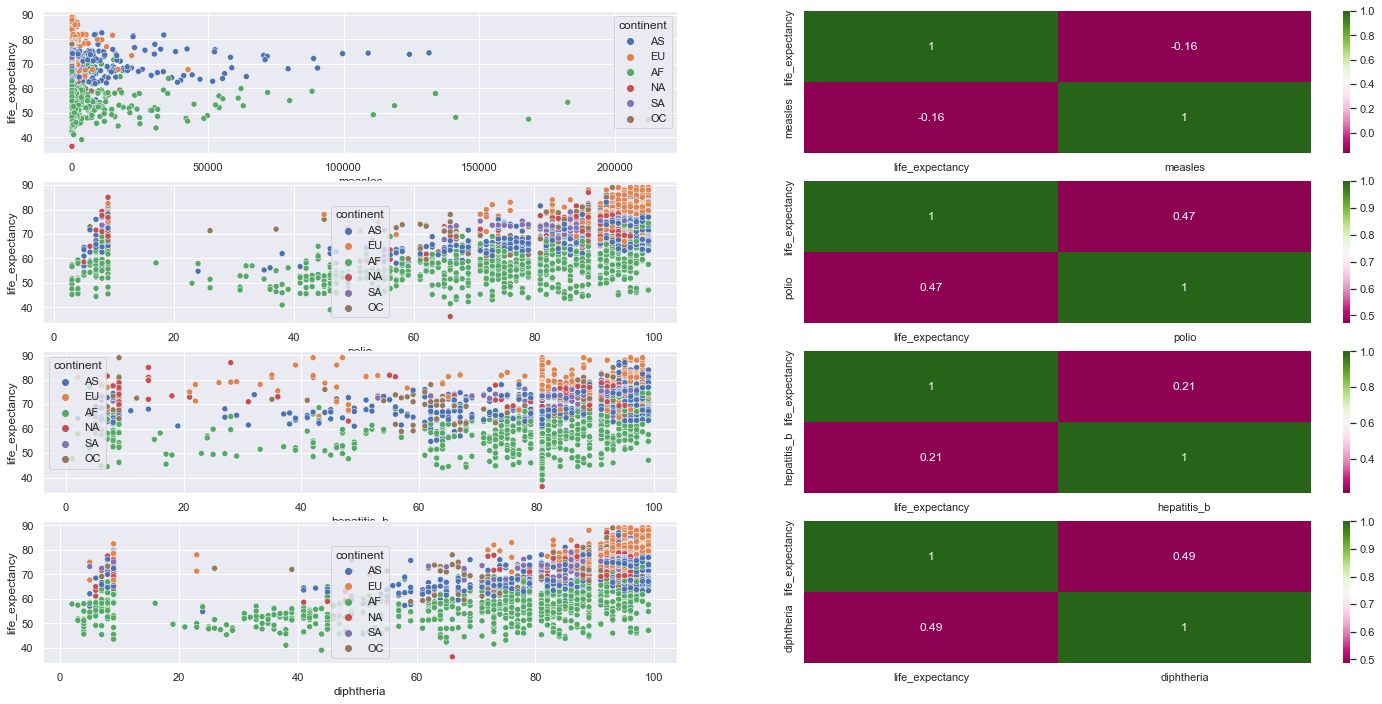

In [348]:
aux7 = df2[['life_expectancy','measles','continent']]
aux8 = df2[['life_expectancy','polio','continent']]
aux9 = df2[['life_expectancy','hepatitis_b','continent']]
aux0 = df2[['life_expectancy','diphtheria','continent']]

plt.subplot( 4, 2, 1 )
sns.scatterplot(x='measles',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 4, 2, 2 )
sns.heatmap(aux7.corr(method='pearson'),annot=True,cmap="PiYG");

plt.subplot( 4, 2, 3 )
sns.scatterplot(x='polio',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 4, 2, 4 )
sns.heatmap(aux8.corr(method='pearson'),annot=True,cmap="PiYG");

plt.subplot( 4, 2, 5 )
sns.scatterplot(x='hepatitis_b',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 4, 2, 6)
sns.heatmap(aux9.corr(method='pearson'),annot=True,cmap="PiYG");

plt.subplot( 4, 2, 7 )
sns.scatterplot(x='diphtheria',y='life_expectancy',hue='continent', data=df2);

plt.subplot( 4, 2, 8)
sns.heatmap(aux0.corr(method='pearson'),annot=True,cmap="PiYG");

### **H9**  - A expectativa de vida tem correlação positiva ou negativa com hábitos alimentares, estilo de vida, exercícios, fumo, bebida alcoólica etc.


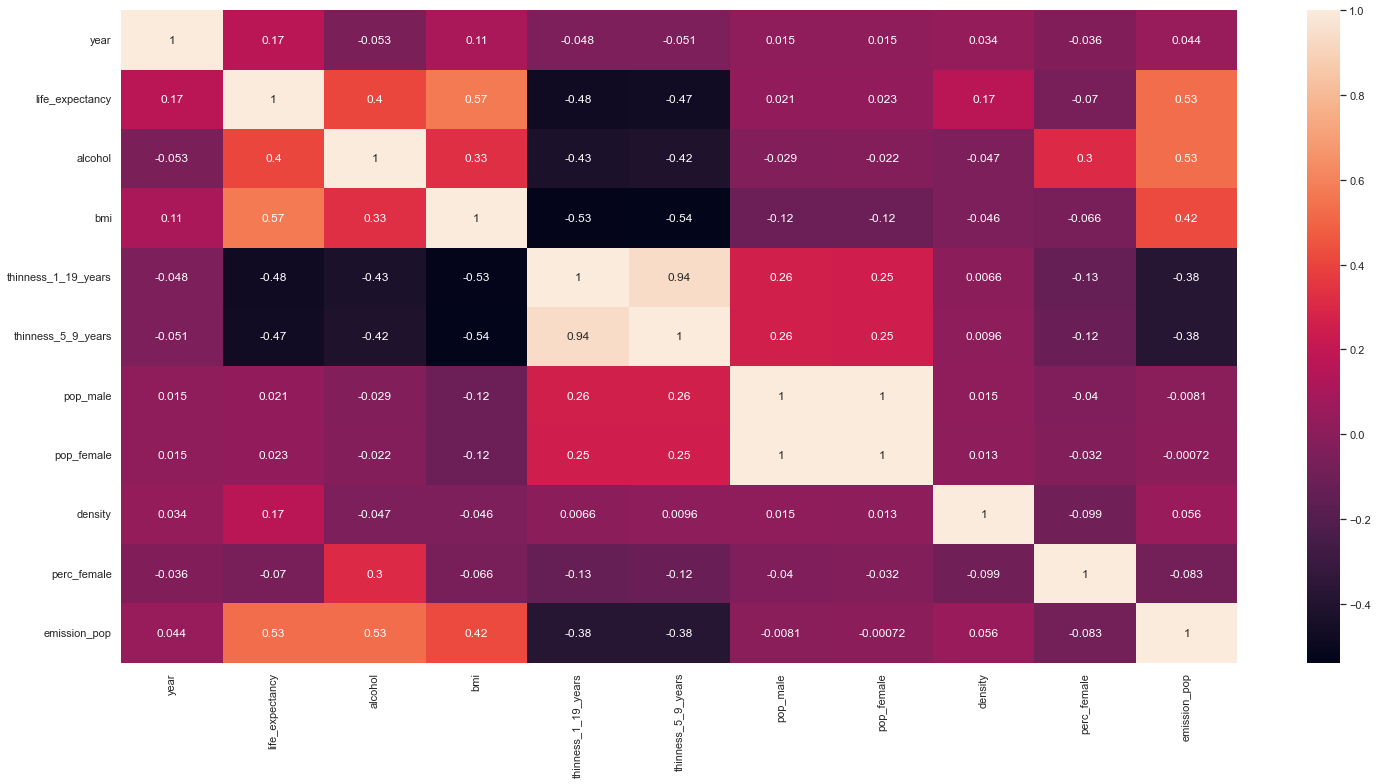

In [349]:
cols_drop = ['adult_mortality','infant_deaths',
             'percentage_expenditure', 'hepatitis_b','measles', 'under_five_deaths', 'polio', 'total_expenditure', 'diphtheria', 'gdp','pop_total','hiv_aids', 'income_composition_of_resources', 'schooling','emission', 'lat', 'long']

num_attributes1=num_attributes.drop(cols_drop, axis=1 )
correlation = num_attributes1.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### Numerical Heatmap 

In [350]:
df3=df2.copy()
num_attributes4 = df3.select_dtypes( include=['int64', 'float64'] )
cat_attributes4 = df3.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

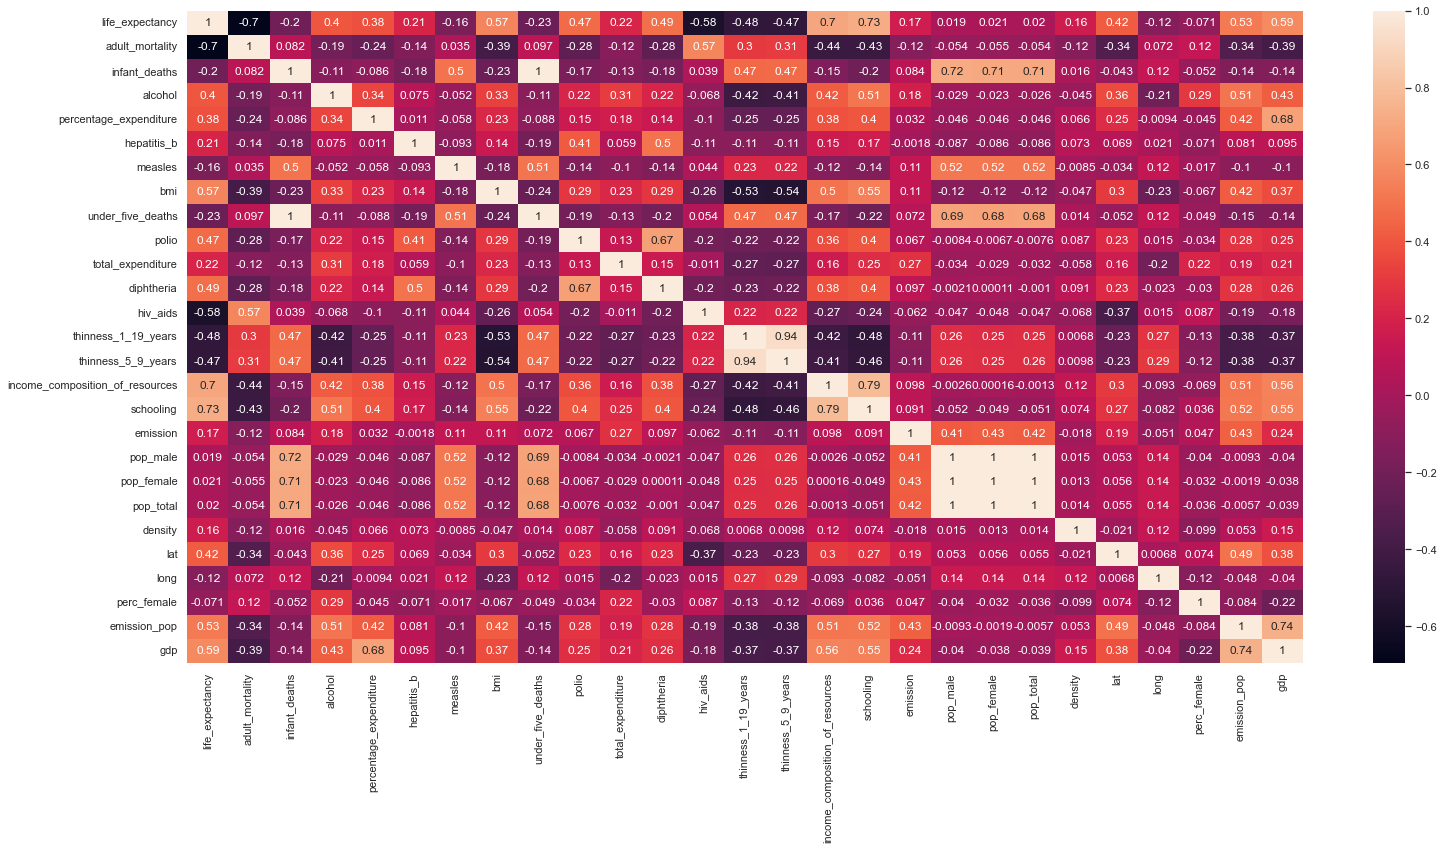

In [351]:
correlation = num_attributes4.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### Categorical Heatmap 

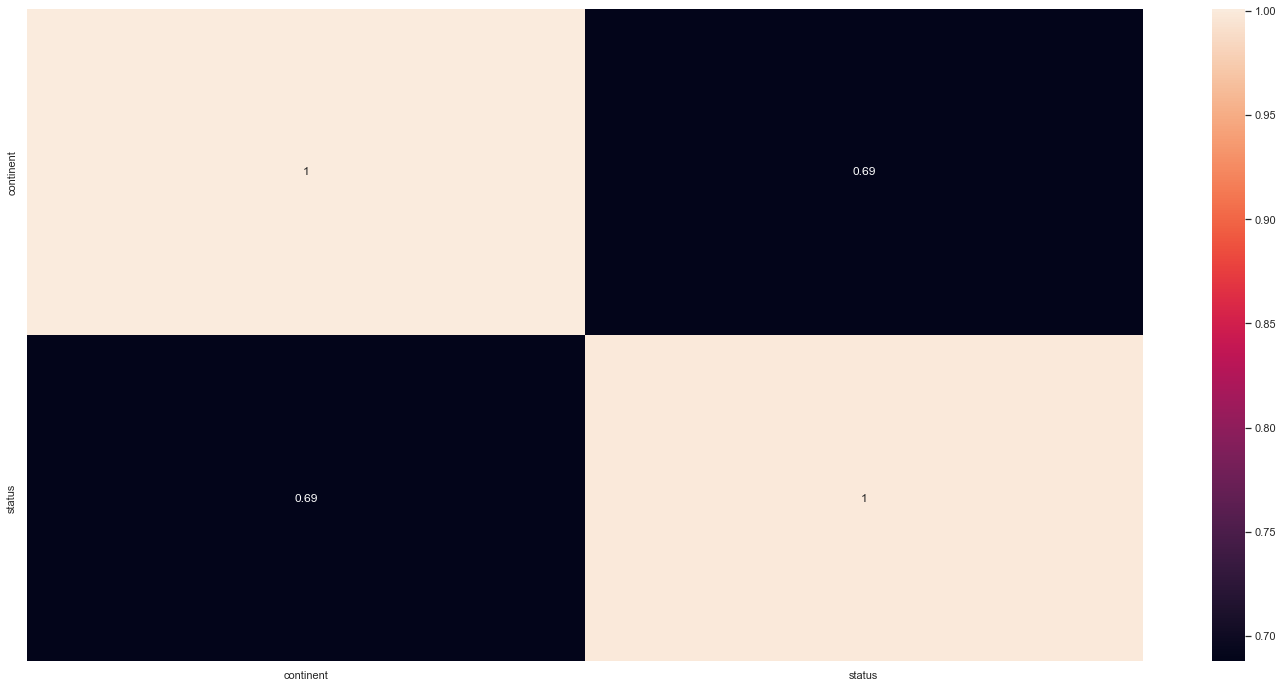

In [352]:
# # # Calculate cramer V
a = df2.select_dtypes( include='object' )

a1 = cramer_v( a['continent'], a['continent'] )
a2 = cramer_v( a['continent'], a['status'] )
a3 = cramer_v( a['status'], a['continent'] )
a4 = cramer_v( a['status'], a['status'] )



# # Final dataset
d = pd.DataFrame( {'continent': [a1, a2],'status': [a3, a4]})
d = d.set_index( d.columns )
sns.heatmap( d, annot=True );

## **Preprocessing Data**

In [365]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [366]:
df3=df2.copy()

In [367]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 2937
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2872 non-null   object 
 1   year                             2872 non-null   object 
 2   status                           2872 non-null   object 
 3   life_expectancy                  2872 non-null   float64
 4   adult_mortality                  2872 non-null   float64
 5   infant_deaths                    2872 non-null   int64  
 6   alcohol                          2872 non-null   float64
 7   percentage_expenditure           2872 non-null   float64
 8   hepatitis_b                      2872 non-null   float64
 9   measles                          2872 non-null   int64  
 10  bmi                              2872 non-null   float64
 11  under_five_deaths                2872 non-null   int64  
 12  polio               

In [368]:
rs = RobustScaler()
mms = MinMaxScaler()
le=LabelEncoder()

### Robust Scaler

**Variaveis a serem rescaladas:** (problema con range)
 - emission
 - gdp
 - infant_deaths
 - percentage_expenditure
 - measles
 - under_five_deaths
 - pop_male
 - pop_female
 - pop_total
 - density
 - perc_female
 - emission_pop


In [369]:
df3['emission'] = rs.fit_transform( df3[['emission']].values )
df3['gdp'] = rs.fit_transform( df3[['gdp']].values )
df3['infant_deaths'] = rs.fit_transform( df3[['infant_deaths']].values )
df3['percentage_expenditure'] = rs.fit_transform( df3[['percentage_expenditure']].values )
df3['measles'] = rs.fit_transform( df3[['measles']].values )
df3['under_five_deaths'] = rs.fit_transform( df3[['under_five_deaths']].values )
df3['pop_male'] = rs.fit_transform( df3[['pop_male']].values )
df3['pop_female'] = rs.fit_transform( df3[['pop_female']].values )
df3['pop_total'] = rs.fit_transform( df3[['pop_total']].values )
df3['density'] = rs.fit_transform( df3[['density']].values )
df3['perc_female'] = rs.fit_transform( df3[['perc_female']].values )
df3['emission_pop'] = rs.fit_transform( df3[['emission_pop']].values )

### Transformation

#### Order Encoder

 - year

In [370]:
a=['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015']
b=np.arange(1,17,1)
year_dict = dict(zip(a, b))
df3['year']=df3['year'].map(year_dict)
df3

country  year      status  life_expectancy  adult_mortality  infant_deaths  alcohol  percentage_expenditure  hepatitis_b  measles   bmi  under_five_deaths  polio  total_expenditure  diphtheria  hiv_aids  thinness_1_19_years  thinness_5_9_years  income_composition_of_resources  schooling  emission  pop_male  pop_female  pop_total  density    lat    long continent     code  perc_female  emission_pop   gdp
0                                           Afghanistan    16  Developing            65.00           263.00           2.81     0.01                    0.01        65.00     3.17 19.10               3.04   6.00               8.16       65.00      0.10                17.20               17.30                             0.48      10.10     -0.08      1.22        1.12       1.16    -0.17  33.77   66.24        AS       AF        -1.31         -0.21 -0.28
1                                           Afghanistan    15  Developing            59.90           271.00           2.90     0.01                    0.01        62.00     1.32 18.60               3.15  58.00               8.18       62.00      0.10                17.50               17.50                             0.48      10.00     -0.09      1.17        1.08       1.12    -0.18  33.77   66.24        AS       AF        -1.28         -0.21 -0.27
2                                           Afghanistan    14  Developing            59.90           268.00           3.00     0.01                    0.01        64.00     1.15 18.10               3.27  62.00               8.13       64.00      0.10                17.70               17.70                             0.47       9.90     -0.09      1.12        1.03       1.07    -0.20  33.77   66.24        AS       AF        -1.24         -0.22 -0.27
3                                           Afghanistan    13  Developing            59.50           272.00           3.14     0.01                    0.02        67.00     7.72 17.60               3.42  67.00               8.52       67.00      0.10                17.90               18.00                             0.46       9.80     -0.10      1.07        0.98       1.02    -0.21  33.77   66.24        AS       AF        -1.19         -0.22 -0.27
4                                           Afghanistan    12  Developing            59.20           275.00           3.24     0.01                   -0.13        68.00     8.35 17.20               3.58  68.00               7.87       68.00      0.10                18.20               18.20                             0.45       9.50     -0.10      1.02        0.94       0.97    -0.23  33.77   66.24        AS       AF        -1.15         -0.22 -0.27
5                                           Afghanistan    11  Developing            58.80           279.00           3.38     0.01                    0.03        66.00     5.50 16.70               3.77  66.00               9.20       66.00      0.10                18.40               18.40                             0.45       9.20     -0.11      0.97        0.90       0.93    -0.24  33.77   66.24        AS       AF        -1.15         -0.22 -0.28
6                                           Afghanistan    10  Developing            58.60           281.00           3.52     0.01                   -0.02        63.00     7.93 16.20               3.92  63.00               9.42       63.00      0.10                18.60               18.70                             0.43       8.90     -0.11      0.94        0.86       0.89    -0.25  33.77   66.24        AS       AF        -1.18         -0.22 -0.29
7                                           Afghanistan     9  Developing            58.10           287.00           3.67     0.03                   -0.09        64.00     4.41 15.70               4.08  64.00               8.33       64.00      0.10                18.80               18.90                             0.43       8.70     -0.11      0.91        0.83       0.86    -0.26  33.77   66.24      

#### Label Encoder


- status
- continent
- code
- country

In [371]:
# Label Encoder
df3['status']=le.fit_transform(df3['status'])
df3['continent']=le.fit_transform(df3['continent'])
df3['country']=le.fit_transform(df3['country'])
df3['code']=le.fit_transform(df3['code'])

#### Response varable  Transformation

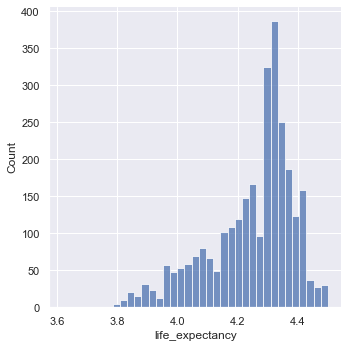

In [372]:
df3['life_expectancy']=np.log1p(df3['life_expectancy'])
sns.displot(df3['life_expectancy']);

## Features Selection

In [373]:
df4=df3.copy()
df4.head()

country  year  status  life_expectancy  adult_mortality  infant_deaths  alcohol  percentage_expenditure  hepatitis_b  measles   bmi  under_five_deaths  polio  total_expenditure  diphtheria  hiv_aids  thinness_1_19_years  thinness_5_9_years  income_composition_of_resources  schooling  emission  pop_male  pop_female  pop_total  density   lat  long  continent  code  perc_female  emission_pop   gdp
0        0    16       1             4.19           263.00           2.81     0.01                    0.01        65.00     3.17 19.10               3.04   6.00               8.16       65.00      0.10                17.20               17.30                             0.48      10.10     -0.08      1.22        1.12       1.16    -0.17 33.77 66.24          1     1        -1.31         -0.21 -0.28
1        0    15       1             4.11           271.00           2.90     0.01                    0.01        62.00     1.32 18.60               3.15  58.00               8.18       62.00      0.10                17.50               17.50                             0.48      10.00     -0.09      1.17        1.08       1.12    -0.18 33.77 66.24          1     1        -1.28         -0.21 -0.27
2        0    14       1             4.11           268.00           3.00     0.01                    0.01        64.00     1.15 18.10               3.27  62.00               8.13       64.00      0.10                17.70               17.70                             0.47       9.90     -0.09      1.12        1.03       1.07    -0.20 33.77 66.24          1     1        -1.24         -0.22 -0.27
3        0    13       1             4.10           272.00           3.14     0.01                    0.02        67.00     7.72 17.60               3.42  67.00               8.52       67.00      0.10                17.90               18.00                             0.46       9.80     -0.10      1.07        0.98       1.02    -0.21 33.77 66.24          1     1        -1.19         -0.22 -0.27
4        0    12       1             4.10           275.00           3.24     0.01                   -0.13        68.00     8.35 17.20               3.58  68.00               7.87       68.00      0.10                18.20               18.20                             0.45       9.50     -0.10      1.02        0.94       0.97    -0.23 33.77 66.24          1     1        -1.15         -0.22 -0.27

### Split dataframe into training and test dataset

In [374]:
# features deletar variaveis derivdas
cols_drop = ['code','thinness_5_9_years','pop_male','pop_female']

df4=df4.drop(cols_drop, axis=1)

In [375]:
# training dataset
X_train = df4[df4['year'] < 14]
y_train = X_train['life_expectancy']

# # test dataset(sem contaminaçao)
# X_test = df1[df1['year'] >= 14]
# y_test = X_test['life_expectancy']


# test dataset
X_test = df4[df4['year'] >= 14]
y_test = X_test['life_expectancy']

print( 'Training Min Date: {}'.format( X_train['year'].min() ) )
print( 'Training Max Date: {}'.format( X_train['year'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['year'].min() ) )
print( 'Test Max Date: {}'.format( X_test['year'].max() ) )

Training Min Date: 1
Training Max Date: 13

Test Min Date: 14
Test Max Date: 16


### Seleçao por subset -Boruta

In [376]:
# ## training and test dataset for Boruta
X_train_n = X_train.drop(['life_expectancy','year'],axis=1).values
y_train_n = y_train.values.ravel()


# # ## define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 ) # cria as arvores em paralelo

# # define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=15 ).fit( X_train_n, y_train_n )# devo passar um vetor 

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	23
Tentative: 	3
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	23
Tentative: 	3
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	23
Tentative: 	2
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	23
Tentative: 	2
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	23
Tentative: 	2
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	23
Tentative: 	2
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	23
Tentative: 	2
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	23
Tentative: 	2
Rejected: 	1
Iteration: 	16 / 100
Confirmed: 	23
Tentative: 	2
Rejected: 	1
I

In [377]:
cols_selected = boruta.support_.tolist()

## best features
X_train_fs = X_train.drop( [ 'life_expectancy','year'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# ## not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) ) 

In [378]:
cols_selected_boruta

['country',
 'adult_mortality',
 'infant_deaths',
 'alcohol',
 'percentage_expenditure',
 'bmi',
 'under_five_deaths',
 'polio',
 'total_expenditure',
 'diphtheria',
 'hiv_aids',
 'thinness_1_19_years',
 'income_composition_of_resources',
 'schooling',
 'emission',
 'pop_total',
 'density',
 'lat',
 'long',
 'continent',
 'perc_female',
 'emission_pop',
 'gdp']

In [ ]:
cols_not_selected_boruta

In [ ]:
correlation = df4[['status','life_expectancy']].corr( method='pearson' )
sns.heatmap( correlation, annot=True );

In [ ]:
features_selection= [
 'country',
 'adult_mortality',
 'infant_deaths',
 'alcohol',
 'percentage_expenditure',
 'hepatitis_b',
 'measles',
 'bmi',
 'under_five_deaths',
 'polio',
 'total_expenditure',
 'diphtheria',
 'hiv_aids',
 'thinness_1_19_years',
 'income_composition_of_resources',
 'schooling',
 'emission',
 'pop_total',
 'density',
 'continent',
 'lat',
 'long',
 'perc_female',
 'emission_pop',
 'gdp']

# columns to add
feat_to_add = ['life_expectancy','year']

features_selection_full = features_selection.copy()
features_selection_full.extend( feat_to_add )

In [ ]:
features_selection_full

## Machine Learning Modelling

In [ ]:
x_train = X_train[ features_selection ]
x_test = X_test[ features_selection ]

# Time Series Data Preparation
x_training = X_train[ features_selection_full ]

### Linear regression model 

In [ ]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

In [ ]:
print( 'Score Train: {}'.format( lr.score(x_train,y_train) ))
print( 'Score Test: {}'.format( lr.score(x_test,y_test) ))

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

#### Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation( x_training, 3, 'Linear Regression', lr, verbose=False )
lr_result_cv

### Linear Regression Regularized Model - Lasso

In [ ]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

In [ ]:
print( 'Score Train: {}'.format( lrr.score(x_train,y_train) ))
print( 'Score Test: {}'.format( lrr.score(x_test,y_test) ))

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

In [ ]:
## Usar os ploters da Aula prática - Colab - Regressão linear, Ridge e LASSO
## Aula prática - Colab - Transformação de Dados


#### Linear Regression Regularized Model - Cross Validation

In [ ]:
lrr_result_cv = cross_validation( x_training, 3, 'Linear Regression - Lasso', lrr, verbose=False )
lrr_result_cv

### Linear Regression Regularized Model - Ridge

In [ ]:
# model
lrri = Ridge( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrri = lrri.predict( x_test )


In [ ]:
print( 'Score Train: {}'.format( lrri.score(x_train,y_train) ))
print( 'Score Test: {}'.format( lrri.score(x_test,y_test) ))

# performance
lrri_result = ml_error( 'Linear Regression - Ridge', np.expm1( y_test ), np.expm1( yhat_lrri ) )
lrri_result

#### Linear Regression Regularized Model - Cross Validation

In [ ]:
lrri_result_cv = cross_validation( x_training, 3, 'Linear Regression - Ridge', lrri, verbose=False )
lrri_result_cv

### Random Forest Regressor

In [ ]:
RandomForestRegressor().get_params()

In [ ]:
# model
rf = RandomForestRegressor( bootstrap= True,
                           criterion='mse',
                           min_samples_leaf= 1,
                           min_samples_split= 2,
                           n_estimators=100, 
                           n_jobs=-1, 
                          ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

In [ ]:
print( 'Score Train: {}'.format( rf.score(x_train,y_train) ))
print( 'Score Test: {}'.format( rf.score(x_test,y_test) ))

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

#### Ramdom Forest- Cross Validation

In [ ]:
rf_result_cv = cross_validation( x_training, 3, 'Random Forest Regressor', rf, verbose=False )
rf_result_cv

### XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              max_depth=5, 
                              subsample=0.7
                             ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

#### XGBoost - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 3, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv

## Performance Metrics

In [ ]:
modelling_result = pd.concat( [lr_result, lrr_result,lrri_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

### Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, lrri_result_cv,rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )

## Fine Tunning

### Random search

In [116]:
from sklearn.model_selection       import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble              import RandomForestClassifier


In [117]:
# Create the parameter grid based on the results of random search 
bootstrap= [1,0],
criterion=['mse']
min_samples_leaf= [0.5, 0.75, 1, 2],
min_samples_split= [0.5, 0.75, 1, 2],
n_estimators= [10, 40, 80, 160, 250]


param_grid = {
   'bootstrap': bootstrap,
   'criterion': criterion,
   'min_samples_leaf': min_samples_leaf,
   'min_samples_split': min_samples_split,
   'n_estimators':n_estimators  
}

n_combinations=1
for k in param_grid.keys():n_combinations*= len(param_grid[k])
    
print('numbers_of_combination =', n_combinations)
    
param_grid



numbers_of_combination = 5


{'bootstrap': ([1, 0],),
 'criterion': ['mse'],
 'min_samples_leaf': ([0.5, 0.75, 1, 2],),
 'min_samples_split': ([0.5, 0.75, 1, 2],),
 'n_estimators': [10, 40, 80, 160, 250]}

In [118]:
# rf = RandomForestRegressor()
    
# model_rf = GridSearchCV(estimator = rf, 
#                               param_grid= param_grid, 
#                               cv = 3, 
#                               return_train_score=1,
#                               n_jobs = -1, 
#                               verbose = 2)
#  # performance
# result = cross_validation( x_training, 3, 'Random Forest Regressor', model_rf, verbose=True )
# #final_result = pd.concat( [final_result, result] )
       
# #final_result


### XGBoost

In [119]:
param = {
   'n_estimators': [100, 500, 1000,10000],
   'max_depth': [1, 2, 5],
   'subsample': [0.1, 0.5, 0.7]
  # 'min_child_weight': [10, 30, 50]
       }


MAX_EVAL = 10

In [120]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
   # choose values for parameters randomly
   hp = { k: np.random.choice( v, 1 )[0] for k, v in param.items() }
   print( hp )
   
   # model
   model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'],
                                 #min_child_weight=hp['min_child_weight'] 
                               )

   # performance
   result = cross_validation( x_training, 3, 'XGBoost Regressor', model_xgb, verbose=True )
   final_result = pd.concat( [final_result, result] )
       
final_result


{'n_estimators': 100, 'max_depth': 1, 'subsample': 0.1}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 500, 'max_depth': 1, 'subsample': 0.5}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1000, 'max_depth': 1, 'subsample': 0.1}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1000, 'max_depth': 1, 'subsample': 0.1}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 100, 'max_depth': 2, 'subsample': 0.7}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 500, 'max_depth': 5, 'subsample': 0.7}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 100, 'max_depth': 1, 'subsample': 0.1}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 10000, 'max_depth': 2, 'subsample': 0.7}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1000, 'max_depth': 5, 'subsample': 0.1}

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 100, 'max_depth

Model Name         MAE CV         MAPE CV        RMSE CV
0  XGBoost Regressor   2.56 +/- 0.1  0.04 +/- 0.002   3.42 +/- 0.1
0  XGBoost Regressor   2.1 +/- 0.06  0.03 +/- 0.001  2.89 +/- 0.06
0  XGBoost Regressor  2.55 +/- 0.15  0.04 +/- 0.003   3.4 +/- 0.16
0  XGBoost Regressor  2.55 +/- 0.15  0.04 +/- 0.003   3.4 +/- 0.16
0  XGBoost Regressor  1.84 +/- 0.05  0.03 +/- 0.001  2.63 +/- 0.08
0  XGBoost Regressor  1.68 +/- 0.12  0.03 +/- 0.002  2.49 +/- 0.15
0  XGBoost Regressor   2.56 +/- 0.1  0.04 +/- 0.002   3.42 +/- 0.1
0  XGBoost Regressor  1.69 +/- 0.01  0.03 +/- 0.001  2.48 +/- 0.04
0  XGBoost Regressor  4.13 +/- 0.18  0.06 +/- 0.003  5.44 +/- 0.31
0  XGBoost Regressor   2.56 +/- 0.1  0.04 +/- 0.002   3.42 +/- 0.1

### Final Model

#### Final tune XGBoost

In [121]:
param_tuned = {
    'n_estimators': 10000,
    'max_depth': 2,
    'subsample': 0.7,
        }


In [122]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

Model Name  MAE  MAPE  RMSE
0  XGBoost Regressor 1.59  0.02  2.26

#### Final Model Random Forest

In [123]:
# model
rf = RandomForestRegressor( bootstrap= True,
                           criterion='mse',
                           min_samples_leaf= 1,
                           min_samples_split= 2,
                           n_estimators=100, 
                           n_jobs=-1, 
                          ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

print( 'Score Train: {}'.format( rf.score(x_train,y_train) ))
print( 'Score Test: {}'.format( rf.score(x_test,y_test) ))

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

Score Train: 0.9955474403657492
Score Test: 0.9237426242640714


Model Name  MAE  MAPE  RMSE
0  Random Forest Regressor 1.45  0.02  2.25

## Translation and interpretation of the error

In [124]:
df5 = X_test[ features_selection_full ]

# rescale
df5['life_expectancy'] = np.expm1( df5['life_expectancy'] )
df5['predictions'] = np.expm1( yhat_rf )

### Business Performance

In [125]:
sns.scatterplot( x='country', y='MAPE', data=df52 );

NameError: name 'df52' is not defined

In [126]:
# sum of predictions
df51 = df5[['country', 'predictions']].groupby( 'country' ).mean().reset_index()

# # MAE and MAPE
df5_aux1 = df5[['country', 'life_expectancy', 'predictions']].groupby( 'country' ).apply( lambda x: mean_absolute_error( x['life_expectancy'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df5_aux2 = df5[['country', 'life_expectancy', 'predictions']].groupby( 'country' ).apply( lambda x: mean_absolute_percentage_error( x['life_expectancy'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df5_aux3 = pd.merge( df5_aux1, df5_aux2, how='inner', on='country' )
df52 = pd.merge( df51, df5_aux3, how='inner', on='country' )

# # Scenarios
df52['worst_scenario'] = df52['predictions'] - df52['MAE']
df52['best_scenario'] = df52['predictions'] + df52['MAE']

# # order columns
df52 = df52[['country', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [127]:
a=['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015']
b=np.arange(1,17,1)
year_dict = dict(zip(a, b))
df5['year']=df5['year'].map(year_dict)

df52.sort_values( 'MAPE', ascending=False ).head()


country  predictions  worst_scenario  best_scenario  MAE  MAPE
143      143        59.04           51.03          67.05 8.01  0.16
179      179        55.89           50.38          61.40 5.51  0.09
149      149        59.24           53.84          64.63 5.40  0.08
170      170        57.86           52.88          62.83 4.98  0.08
25        25        63.97           59.40          68.55 4.57  0.08

### Total Performance

In [128]:
df53 = df52[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.mean( x ), 
                                                            axis=0 ).reset_index().rename( columns=
                                                            {'index': 'Scenario', 0:'Years'} )
df53['Years'] = df53['Years'].map( '{:,.2f}'.format )
df53

Scenario  Years
0     predictions  71.38
1  worst_scenario  69.93
2   best_scenario  72.82

### Machine Learning Performance

In [137]:
df5['error'] = df5['life_expectancy'] - df5['predictions']
df5['error_rate'] = df5['predictions'] / df5['life_expectancy']


a=np.arange(1,17,1)
b=['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015']
year_dict = dict(zip(a, b))
df5['year']=df5['year'].map(year_dict)

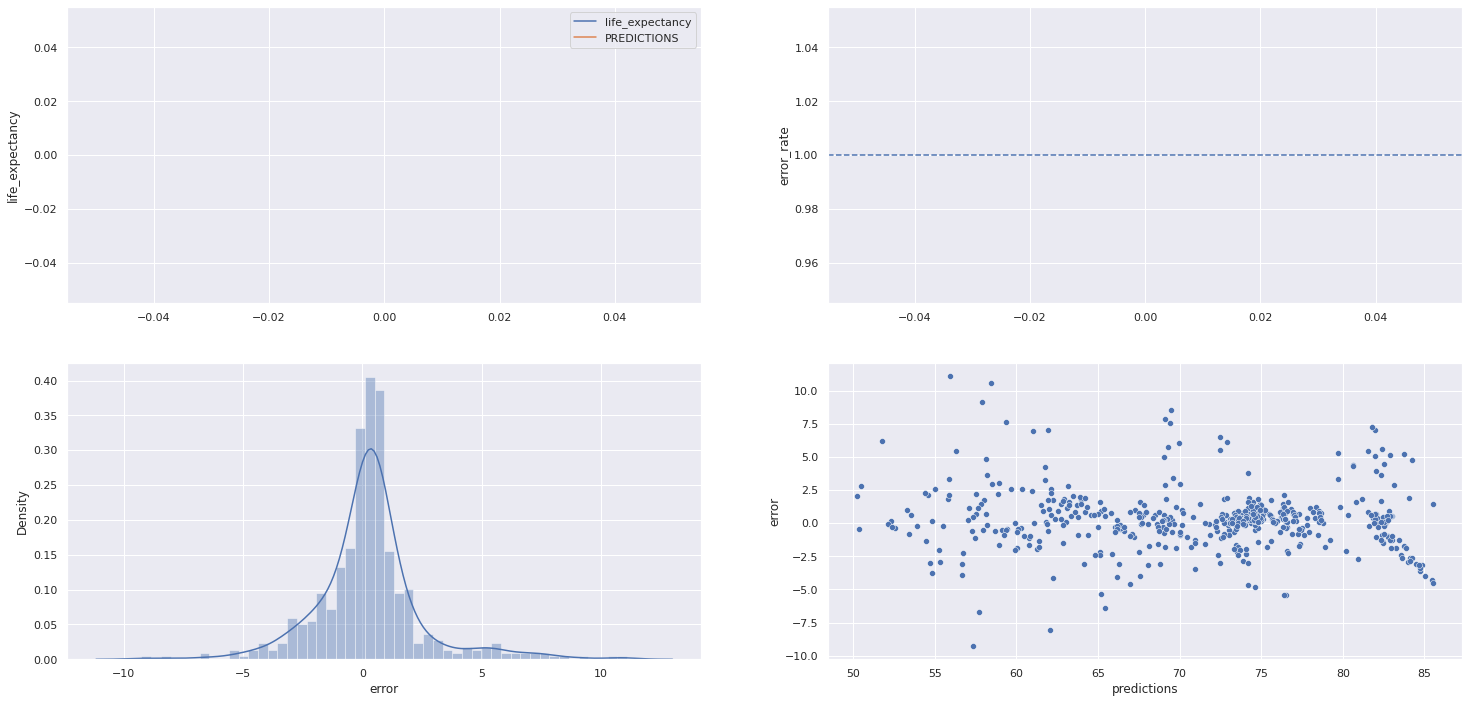

In [138]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='year', y='life_expectancy', data=df5, label='life_expectancy' )
sns.lineplot( x='year', y='predictions', data=df5, label='PREDICTIONS' );


plt.subplot( 2, 2, 2 )
sns.lineplot( x='year', y='error_rate', data=df5 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df5['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df5['predictions'], df5['error'] );

## Scenarios _ Simulation

In [131]:
rf_result

Model Name  MAE  MAPE  RMSE
0  Random Forest Regressor 1.45  0.02  2.25

In [132]:
# x_train_sc1 = X_train[ features_selection ]
# x_train_sc1['schooling']=x_train_sc1['schooling']*1.5

# x_test_sc1 = X_test[ features_selection ]
# x_test_sc1['schooling']=x_test_sc1['schooling']*1.5


In [133]:
# # model
# rf_sc1 = RandomForestRegressor( bootstrap= True,
#                            criterion='mse',
#                            min_samples_leaf= 1,
#                            min_samples_split= 2,
#                            n_estimators=100, 
#                            n_jobs=-1, 
#                           ).fit( x_train_sc1, y_train )

# # prediction
# yhat_rf_sc1 = rf_sc1.predict( x_test_sc1 )
# np.expm1(yhat_rf_sc1)
# np.expm1(yhat_rf)


In [134]:
# sum of predictions
df51 = df5[['country', 'predictions']].groupby( 'country' ).mean().reset_index()

# # MAE and MAPE
df5_aux1 = df5[['country', 'life_expectancy', 'predictions']].groupby( 'country' ).apply( lambda x: mean_absolute_error( x['life_expectancy'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df5_aux2 = df5[['country', 'life_expectancy', 'predictions']].groupby( 'country' ).apply( lambda x: mean_absolute_percentage_error( x['life_expectancy'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df5_aux3 = pd.merge( df5_aux1, df5_aux2, how='inner', on='country' )
df52 = pd.merge( df51, df5_aux3, how='inner', on='country' )

# # Scenarios
df52['worst_scenario'] = df52['predictions'] - df52['MAE']
df52['best_scenario'] = df52['predictions'] + df52['MAE']

# # order columns
df52 = df52[['country', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [135]:
a=['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015']
b=np.arange(1,17,1)
year_dict = dict(zip(a, b))
df5['year']=df5['year'].map(year_dict)

df52.sort_values( 'MAPE', ascending=False ).head()


country  predictions  worst_scenario  best_scenario  MAE  MAPE
143      143        59.04           51.03          67.05 8.01  0.16
179      179        55.89           50.38          61.40 5.51  0.09
149      149        59.24           53.84          64.63 5.40  0.08
170      170        57.86           52.88          62.83 4.98  0.08
25        25        63.97           59.40          68.55 4.57  0.08

In [136]:
print( 'Score Train: {}'.format( rf_sc1.score(x_train,y_train) ))
print( 'Score Test: {}'.format( rf_sc1.score(x_test,y_test) ))

# perf_sc1ormance
rf_sc1_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf_sc1 ) )
rf_sc1_result

NameError: name 'rf_sc1' is not defined